## Chapter 5: AI in Medicine - Time-Series Analysis
### Part 1: Time Series Classification using Classical Machine Learning for Atrial Fibrillation Detection

Welcome! In this part of the exercises, we'll walk through a full machine learning pipeline for detecting **Atrial Fibrillation (AF)** using ECG data.

**This week's exercise has 7 tasks and 1 bonus task (all marked with a 🧩 symbol) for a total of 10+1 points. Don't forget to submit your solutions to GitHub!**

---

We’ll start with a short introduction to the topic.  
After that, there will be time for you to work through the notebook, fill in missing code where needed, and ask questions - we’ll be available to help throughout.

---

**🎯 Objectives**  
- Load and understand ECG data  
- Calculate features based on a scientific paper  
- Train and evaluate classical ML classifiers for AF detection

**🩺 Clinical Task**  
- Classify short ECG windows as **AF** or **non-AF**

**🧩  YOUR Tasks**
- Task 1 — Implement a Butterworth Bandpass Filter for ECG - **2 points**
- Task 2 — Detect R-peaks - **1 point**
- Task 3 — Compute Statistical Features from RR Intervals - **1 point**
- Task 4 — Leakage free Standarization of Features - **1 point**
- Task 5 - Interpretation of error analysis **2 points**
- Bonus Task — Calculate imbalance ratio for XGBoost - **1 point**

<br>

### Part 2: Time Series Forecasting of ECG recording

In Part 2 of this exercise, we'll reuse the raw ECG data for time series forecasting tasks. We will use a Transformer Model and a Time Series Foundation Model for this.

---

We’ll start again with a short introduction to the topic.  
After that, there will be time for you to work through the notebook, fill in missing code where needed, and ask questions.

---

**🎯 Objectives**  
-  Understand the principles of time-series forecasting in physiological signals (e.g., ECG).
- Learn how Transformer-based models can be adapted for medical time series data.
-  Compare traditional and foundation model approaches for forecasting physiological signals.

**🩺 Clinical Task**  
- Forecast future ECG signal segments based on previous heart activity to anticipate potential arrhythmias or irregular patterns.

**🧩  YOUR Tasks**
- Task 6 — Baseline & Comparison: Implement baseline forecasters and  compare model performance  - **2 points**
- Task 7 — Error Analysis: For the PatchTST model, identify and plot the time series windows for which the model produced the worst forecasts. - **1 point**



# Part 1: Detecting Atrial Fibrillation in Long-Term ECG Recordings  
## ECG fundamentals, what AF is, and the data we’ll use  

---

**What is an ECG?**  
An electrocardiogram is a voltage trace captured by electrodes on the skin. Each heartbeat follows a characteristic sequence:

* **P-wave** – depolarisation of the atria, leading to atrial contraction.  
* **QRS complex** – rapid depolarisation and contraction of the ventricles.  
* **T-wave** – ventricular repolarisation as the heart resets and the ventricles relax for the next beat.


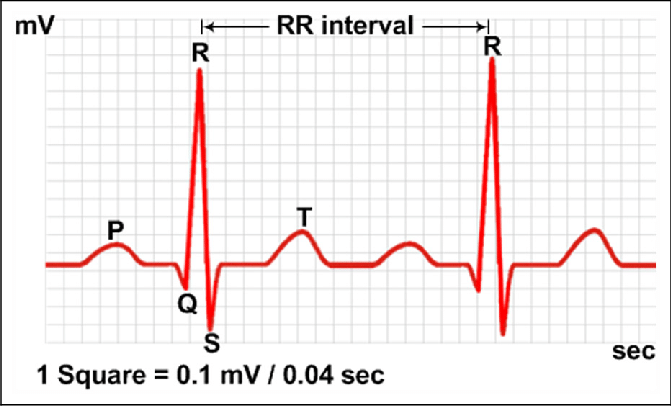

*A single heartbeat on the ECG trace with the P-wave, QRS complex, and T-wave. Source: Keidar et al. 2021*

In [1]:
# Let's see a graph of ECG where we can identify the P-wave, QRS complex, and T-wave
from IPython.display import Image, display, Markdown
display(Image("https://raw.githubusercontent.com/gernotpuc/ai-in-medicine-ts/main/ecg.png"))

display(Markdown(
    "*A single heartbeat on the ECG trace with the P-wave, QRS complex, and T-wave. Source: Keidar et al. 2021*"
))


---

### 🫀 What is Atrial Fibrillation (AF) ?

Atrial fibrillation is a common type of irregular heartbeat caused by disorganized electrical activity in the atria (the upper chambers of the heart). Instead of beating in a steady rhythm, the atria quiver rapidly and unpredictably.

This condition is important to detect because it can lead to serious complications, such as stroke, heart failure, or blood clots. Early diagnosis allows timely treatment to reduce these risks.

On an ECG, AF is identified by:
- **No clear P-waves**, since the atria are not contracting normally  
- **Irregular RR intervals**, meaning the time between heartbeats varies  
- **Erratic baseline**, where the line between beats is uneven and unstable due to chaotic atrial signals  


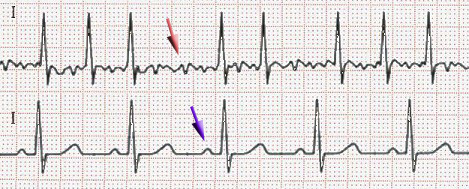

**ECG samples showing atrial fibrillation in the upper trace:** absence of P waves (red arrow), a chaotic baseline between QRS complexes, and irregular RR intervals.  
**Bottom trace shows normal sinus rhythm:** visible P waves (purple arrow) and regular RR intervals.

In [2]:
# Let's compare ECG segments: atrial fibrillation vs. normal sinus rhythm
from IPython.display import Image, display
display(Image("https://raw.githubusercontent.com/gernotpuc/ai-in-medicine-ts/main/ecg_diff.jpeg"))
display(Markdown(
    "**ECG samples showing atrial fibrillation in the upper trace:** absence of P waves (red arrow), a chaotic baseline between QRS complexes, and irregular RR intervals.  \n"
    "**Bottom trace shows normal sinus rhythm:** visible P waves (purple arrow) and regular RR intervals."
))

---
### Dataset: Long-Term Atrial Fibrillation Database (LTAFDB)

We’ll use the Long-Term Atrial Fibrillation Database (LTAFDB), which contains 84 full-day ECG recordings (~24 hours each), sampled at 128 Hz with two leads.
Each time point is labeled as AF (1) or non-AF (0).

We'll work directly with the raw ECG signals. In order not to compute for too long, we will restrict our extraction to a single patient.

Then, we will extract features, computed over fixed-length windows of 150 heartbeats - a setup based on the method from:

Keidar et al., Frontiers in Physiology, 2021

We will perform the windowing and feature extraction and use them to train a machine learning classifier that predicts whether each window shows AF or not.
This kind of feature extraction from raw signals is a common practice in classical machine learning.

👉 In part II of the exercise, we’ll also explore transformer models using raw ECG data for time series forecasting tasks.

---
### 📊 The Features We’ll Use

The features are based on RR intervals - the time between two successive R-peaks in the ECG (the tall spikes in the signal).  
R-peaks can be detected using standard algorithms.

From the RR intervals, a new time series is created by taking the differences between consecutive RR values.  
This captures how much the time between heartbeats changes from one beat to the next.

Each 150-beat window is then summarized by three features:

- **Mean** - the average change in RR intervals  
- **Variability** - how much those changes fluctuate. Higher values mean more variance in timing between beats.  
- **Normality** - how well the changes fit a normal (Gaussian) distribution, measured using the p-value from a Kolmogorov-Smirnov test (range: 0 to 1). Higher values mean the pattern looks more random and less structured.

These features capture the irregularity of the rhythm and help classify each window as AF or non-AF.

---

**Useful links**  
* Dataset: [PhysioNet - Long-Term AF Database (LTAFDB)](https://physionet.org/content/ltafdb/1.0.0/)  
* Paper: [Keidar N. *et al.* 2021, *Frontiers in Physiology*](https://www.frontiersin.org/articles/10.3389/fphys.2021.637680/full)
---

In [3]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [3]:
# ============================================================
# 🩺 AI in Medicine — ECG Feature Extraction (Student Notebook)
# ============================================================


# Install dependencies
!pip install -q --upgrade pip

!pip install -q \
  numpy \
  scipy \
  pandas \
  matplotlib \
  wfdb \
  tqdm \
  gdown

import numpy as np
import pandas as pd
from scipy import signal, stats
import wfdb
from wfdb import processing as wfproc
from tqdm import tqdm
import os, matplotlib.pyplot as plt

print("Libraries loaded:")
print("wfdb :", wfdb.__version__)
print("numpy:", np.__version__)
print("scipy:", signal.__name__, stats.__name__)
print("pandas:", pd.__version__)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Libraries loaded:
wfdb : 4.3.0
numpy: 2.0.2
scipy: scipy.signal scipy.stats
pandas: 2.3.3


In [ ]:
# --- Download an exemplary short ECG records from PhysioNet ---
!mkdir -p data
import wfdb

SAMPLES = ["42"]  # you could expand this list, but we'll stick to one sample only for the sake of performance.
DB_NAME = "ltafdb"

for rec in SAMPLES:
    print(f"Downloading record {rec} ...")
    wfdb.dl_database(DB_NAME, records=[rec], dl_dir="data", keep_subdirs=False)

print("\n✅ Download complete. Files in /data:")
!ls -lh data | head


Generating record list for: 42
Generating list of all files for: 42
Finished downloading files

✅ Download complete. Files in /data:
total 38M
-rw-r--r-- 1 root root 226K Jan 13 15:00 42.atr
-rw-r--r-- 1 root root  38M Jan 13 15:00 42.dat
-rw-r--r-- 1 root root  118 Jan 13 14:57 42.hea
-rw-r--r-- 1 root root 226K Jan 13 15:00 42.qrs


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
✅ Detected 112799 R-peaks
✅ Processed data/42
Detected 112799 R-peaks, 104884 valid RR intervals
Created 104735 windows of 150 beats each

Feature Descriptive Statistics:
       mean_delta_rr  variability_delta_rr  ks_pvalue_delta_rr
count  104735.000000         104735.000000        1.044570e+05
mean       -0.000002              0.074327        3.044201e-02
std         0.000822              0.096254        1.026860e-01
min        -0.009857              0.000000        6.223487e-39
25%        -0.000157              0.009036        2.179223e-05
50%         0.000000              0.010860        2.761467e-04
75%         0.000157              0.167432        4.124910e-03
max         0.010120              0.441859        9.982761e-01


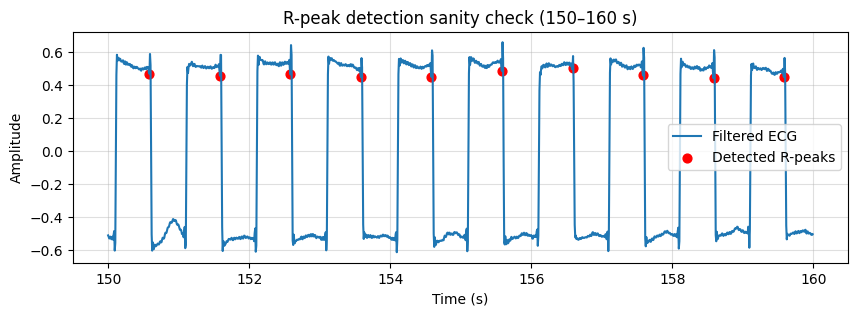

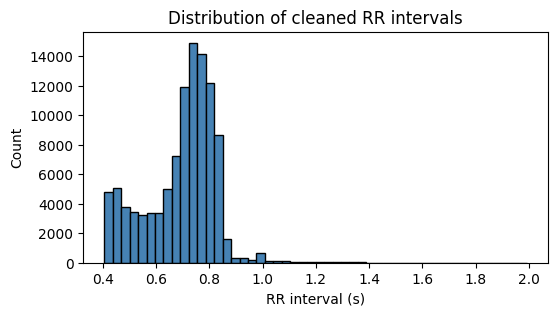


✅ Clean features ready in df: (104735, 3)


In [ ]:
# ============================================================
# 🩺 Robust RR Feature Extraction from Raw ECG
# In this part of the code, you'll find the following 3 tasks to complete:
# 🧩 Task 1 — Implement a Butterworth Bandpass Filter for ECG (2 points)
# 🧩 Task 2 — Detect R-peaks (1 point)
# 🧩 Task 3 — Compute Statistical Features from RR Intervals (1 point)
# ============================================================
import numpy as np
import pandas as pd
from scipy import signal, stats
import wfdb
from wfdb import processing as wfproc
import matplotlib.pyplot as plt

# --- Config ---
WINDOW_BEATS = 150
WINDOW_STEP = 1
LEAD_INDEX = 0           # choose ECG lead
LOWCUT, HIGHCUT = 0.5, 40.0
FILTER_ORDER = 3


# 🧩 Task 1 — Implement a Butterworth Bandpass Filter for ECG

def butter_bandpass(sig, fs, low=LOWCUT, high=HIGHCUT, order=FILTER_ORDER):
    """
    Apply a Butterworth bandpass filter to an ECG signal.

    Parameters
    ----------
    sig : ndarray
        Raw ECG signal.
    fs : float
        Sampling frequency (Hz).
    low, high : float
        Lower and upper cutoff frequencies.
    order : int
        Filter order (higher = steeper cutoff, but more phase distortion).

    Returns
    -------
    sig_f : ndarray
        Filtered ECG signal.
    """
    # --- TODO: Compute the Nyquist frequency
    nyq = fs / 2

    # --- TODO: Normalize cutoff frequencies between 0 and 1
    low_norm = low / nyq
    high_norm = high / nyq

    # --- TODO: Design a Butterworth bandpass filter
    # Use signal.butter
    b, a = signal.butter(order, [low_norm, high_norm], btype='band')

    # --- TODO: Apply zero-phase filtering using signal.filtfilt() ---
    sig_f = signal.filtfilt(b, a, sig)

    return sig_f

# 🧩 Task 2 — Detect R-peaks

def detect_clean_rpeaks(sig_f, fs):
    """
    Detect and clean R-peaks from a filtered ECG signal.

    Try XQRS detection (fast + adaptive).

    """

    # --- TODO: Try detecting R-peaks using the WFDB XQRS detector ---
    try:
        # Hint: create an XQRS object with wfproc.XQRS(sig=sig_f, fs=fs)
        # then call its .detect() method and extract .qrs_inds
        xqrs = wfproc.XQRS(sig=sig_f, fs=fs)
        xqrs.detect()
        rpeaks = np.asarray(xqrs.qrs_inds, dtype=int)
    except Exception:
        # Fallback to GQRS if XQRS fails
        rpeaks = np.asarray(wfproc.gqrs_detect(sig=sig_f, fs=fs), dtype=int)


    # Remove peaks that are too close (<0.35 s apart)
    min_distance = int(0.35 * fs)
    if len(rpeaks) > 1:
        rpeaks = rpeaks[np.insert(np.diff(rpeaks) > min_distance, 0, True)]

    # Normalize ECG polarity
    if len(rpeaks) > 0 and np.mean(sig_f[rpeaks]) < 0:
        sig_f = -sig_f

    # Keep only peaks with the dominant polarity
    if len(rpeaks) > 0:
        polarities = np.sign(sig_f[rpeaks])
        dominant_sign = np.sign(np.median(sig_f[rpeaks]))
        rpeaks = rpeaks[polarities == dominant_sign]

    print(f"✅ Detected {len(rpeaks)} R-peaks")
    return rpeaks, sig_f


# --- Helper: Clean RR intervals ---
def clean_rr(rr):
    """Keep only physiologically plausible RR intervals (0.4–2.0 s)."""
    rr = np.asarray(rr)
    return rr[(rr > 0.4) & (rr < 2.0)]


# 🧩 Task 3 — Compute Statistical Features from RR Intervals

def compute_window_features(rr_sec):
    """
    Compute three features from a sequence of RR intervals (seconds):

    1. Mean change in RR (ΔRR)
    2. Variability (standard deviation of ΔRR)
    3. Normality (KS-test p-value of standardized ΔRR)

    Parameters
    ----------
    rr_sec : array-like
        Sequence of RR intervals in seconds.

    Returns
    -------
    mean_drr : float
        Mean of ΔRR values.
    std_drr : float
        Standard deviation of ΔRR values.
    ks_pval : float
        p-value from KS-test (1 → normal, 0 → non-normal).
    """
    rr_sec = np.asarray(rr_sec)

    # --- Handle very short sequences ---
    if len(rr_sec) < 2:
        return np.nan, np.nan, np.nan

    # --- TODO 1: Compute ΔRR values ---
    drr = np.diff(rr_sec)   # Hint: difference between consecutive RR intervals

    # --- TODO 2: Compute the mean of ΔRR ---
    mean_drr = np.mean(drr)

    # --- TODO 3: Compute standard deviation (sample std, ddof=1) ---
    std_drr = np.std(drr, ddof=1)

    # --- TODO 4: Compute KS-test p-value if variance > 0 ---
    if std_drr > 1e-9:
        # Standardize ΔRR to z-scores
        z = (drr - mean_drr) / std_drr
        _, ks_pval = stats.kstest(z, "norm")
    else:
        ks_pval = np.nan

    return mean_drr, std_drr, ks_pval


# --- Main processing function ---
def process_record(record_path):
    rec = wfdb.rdrecord(record_path)
    fs = rec.fs
    sig = rec.p_signal[:, LEAD_INDEX].astype(float)

    # 1️⃣ Filter ECG
    sig_f = butter_bandpass(sig, fs, LOWCUT, HIGHCUT, FILTER_ORDER)

    # 2️⃣ Detect and clean R-peaks (Task 2)
    rpeaks, sig_f = detect_clean_rpeaks(sig_f, fs)

    # 3️⃣ Compute RR intervals and clean
    rr_intervals = np.diff(rpeaks) / fs
    rr_intervals = clean_rr(rr_intervals)

    if len(rr_intervals) < WINDOW_BEATS:
        raise RuntimeError(f"Too few clean RR intervals ({len(rr_intervals)}) for a {WINDOW_BEATS}-beat window.")

    # 5️⃣ Build overlapping windows
    windows = [rr_intervals[i:i+WINDOW_BEATS]
               for i in range(0, len(rr_intervals) - WINDOW_BEATS + 1, WINDOW_STEP)]

    # 6️⃣ Compute features
    feats = [compute_window_features(w) for w in windows]
    df = pd.DataFrame(feats, columns=["mean_delta_rr", "variability_delta_rr", "ks_pvalue_delta_rr"])

    print(f"✅ Processed {record_path}")
    print(f"Detected {len(rpeaks)} R-peaks, {len(rr_intervals)} valid RR intervals")
    print(f"Created {len(windows)} windows of {WINDOW_BEATS} beats each")

    return df, rr_intervals, rpeaks, sig_f, fs

# ============================================================
# 🧪 Run on one example record
# ============================================================
try:
    record_path = "data/42"
    df, rr_intervals, rpeaks, sig_f, fs = process_record(record_path)

    # --- Feature summary ---
    print("\nFeature Descriptive Statistics:")
    print(df.describe())

    # --- Plot ECG segment (150–200 s) with detected R-peaks ---
    plt.figure(figsize=(10, 3))
    start_s, end_s = 150, 160
    start_idx, end_idx = int(start_s * fs), int(end_s * fs)
    time_segment = np.arange(start_idx, end_idx) / fs
    sig_segment = sig_f[start_idx:end_idx]

    plt.plot(time_segment, sig_segment, label="Filtered ECG")
    rpeaks_in_window = rpeaks[(rpeaks >= start_idx) & (rpeaks < end_idx)]
    plt.scatter(rpeaks_in_window / fs, sig_f[rpeaks_in_window],
                c='r', marker='o', s=40, label="Detected R-peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"R-peak detection sanity check ({start_s}–{end_s} s)")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

    # --- RR interval distribution ---
    plt.figure(figsize=(6, 3))
    plt.hist(rr_intervals, bins=50, color='steelblue', edgecolor='k')
    plt.xlabel("RR interval (s)")
    plt.ylabel("Count")
    plt.title("Distribution of cleaned RR intervals")
    plt.show()

    print("\n✅ Clean features ready in df:", df.shape)

except RuntimeError as e:
    print(f"⚠️ Error: {e}")
except Exception as e:
    if "No such file or directory" in str(e) or "FileNotFoundError" in str(e):
        print(f"❌ Missing data file ('data/00'): {e}")
    else:
        print(f"❌ Unexpected error: {e}")


In [ ]:
# ============================================================
# 🩺 Derive AF labels for each 150-beat window
# NO Tasks - just try to understand the code and execute it.
# ============================================================

import numpy as np
import wfdb

# --- 1️⃣ Read AF rhythm intervals from annotations ---
def rhythm_af_intervals(record_path):
    """
    Reads WFDB rhythm annotations and extracts all intervals
    labeled as (AFIB in the auxiliary notes.
    Returns a list of (start_sample, end_sample) tuples.
    """
    ann = wfdb.rdann(record_path, 'atr')
    aux = np.array(ann.aux_note, dtype=object)
    samp = np.array(ann.sample, dtype=int)

    af_intervals = []
    current_start = None
    for a, s in zip(aux, samp):
        label = a.strip().upper()
        if label.startswith('(AFIB'):
            current_start = s
        elif label.startswith('(') and not label.startswith('(AFIB'):
            if current_start is not None:
                af_intervals.append((current_start, s))
                current_start = None
    # If the last AFIB segment continues to the end of the record:
    if current_start is not None:
        af_intervals.append((current_start, None))
    return af_intervals


# --- 2️⃣ Determine which beats fall inside AF intervals ---
def beats_in_af_mask(rpeaks, af_intervals):
    """
    Create a boolean mask for each beat (R-peak):
    True if that beat lies inside any AF interval.
    """
    mask = np.zeros(len(rpeaks), dtype=bool)
    for start, end in af_intervals:
        if end is None:
            mask |= (rpeaks >= start)
        else:
            mask |= ((rpeaks >= start) & (rpeaks < end))
    return mask


# --- 3️⃣ Window-level labeling rule ---
def window_label_majority(beat_is_af, start_idx, window_beats=150):
    """
    Label a window as AF (1) if >=50% of its beats are AF; otherwise 0.
    """
    w = beat_is_af[start_idx:start_idx + window_beats]
    return int(np.mean(w) >= 0.5) if w.size else 0


# --- 4️⃣ Apply to our record ---
af_intervals = rhythm_af_intervals(record_path)
beat_is_af = beats_in_af_mask(rpeaks, af_intervals)

labels = []
for i in range(0, len(rr_intervals) - WINDOW_BEATS + 1, WINDOW_STEP):  # ✅ +1 ensures alignment with df
    y = window_label_majority(beat_is_af, i, WINDOW_BEATS)
    labels.append(y)

labels = np.array(labels)
print(f"✅ Labeled {len(labels)} windows ({np.sum(labels)} AF, {len(labels) - np.sum(labels)} non-AF)")

# --- 5️⃣ Add to the feature DataFrame ---
if len(labels) == len(df):
    df["label_af"] = labels
    print("\n✅ Labels successfully added to feature DataFrame.")
else:
    print(f"⚠️ Length mismatch: df has {len(df)}, labels have {len(labels)}")

df.head()


✅ Labeled 104735 windows (39286 AF, 65449 non-AF)

✅ Labels successfully added to feature DataFrame.


,mean_delta_rr,variability_delta_rr,ks_pvalue_delta_rr,label_af
0,0.003041,0.274142,2.075036e-21,0
1,0.000577,0.272492,9.656953e-22,0
2,0.001678,0.272153,6.427738e-22,0
3,0.003041,0.271629,3.874223e-22,0
4,0.000734,0.270171,1.680642e-22,0


Index(['mean_delta_rr', 'variability_delta_rr', 'ks_pvalue_delta_rr',
       'label_af'],
      dtype='object')


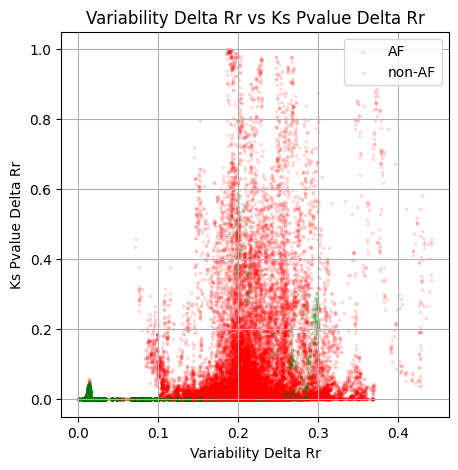

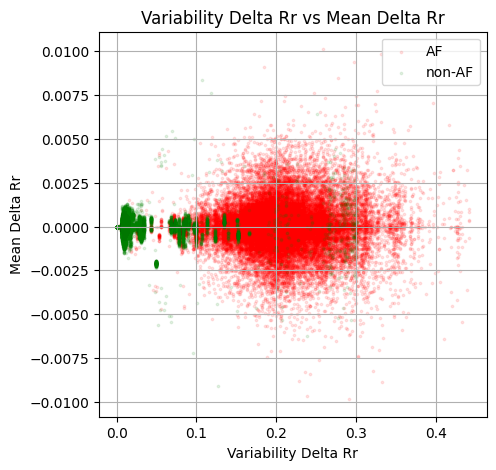

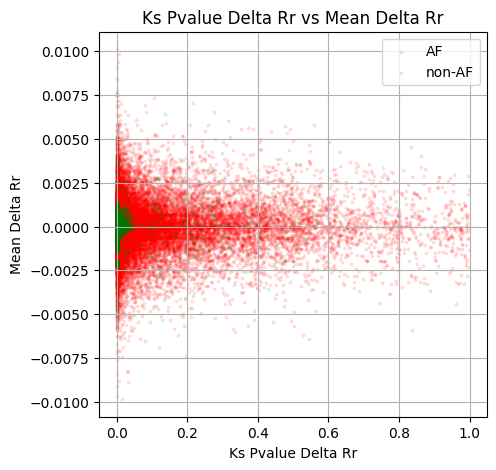

In [ ]:
# ============================================================
# 📊 Visualize feature relationships
# NO Tasks - just try to understand the code and execute it.
# ============================================================
import matplotlib.pyplot as plt

# Make sure your DataFrame looks like this:
print(df.columns)
# ['mean_delta_rr', 'variability_delta_rr', 'ks_pvalue_delta_rr', 'label_af']

def plot_feature_pair(df, feat_x, feat_y):
    """
    Plot two features against each other, color-coded by AF label.
    """
    plt.figure(figsize=(5, 5))
    # Plot AF first (red)
    plt.scatter(
        df.loc[df["label_af"] == 1, feat_x],
        df.loc[df["label_af"] == 1, feat_y],
        c="red", s=3, label="AF", alpha=0.1
    )
    # Plot non-AF second (green) so it lies on top
    plt.scatter(
        df.loc[df["label_af"] == 0, feat_x],
        df.loc[df["label_af"] == 0, feat_y],
        c="green", s=3, label="non-AF", alpha=0.1
    )
    plt.xlabel(feat_x.replace("_", " ").title())
    plt.ylabel(feat_y.replace("_", " ").title())
    plt.title(f"{feat_x.replace('_',' ').title()} vs {feat_y.replace('_',' ').title()}")
    plt.legend()
    plt.grid(True)
    plt.show()


# ✅ Try all feature pairs
plot_feature_pair(df, "variability_delta_rr", "ks_pvalue_delta_rr")  # Variability vs Normality
plot_feature_pair(df, "variability_delta_rr", "mean_delta_rr")       # Variability vs Mean
plot_feature_pair(df, "ks_pvalue_delta_rr", "mean_delta_rr")         # Normality vs Mean


In [ ]:

# Using the NumPy labels array you already built
labels_flat = labels.ravel()  # same as flatten, but cheaper

n_total = labels_flat.size
n_af = int(np.sum(labels_flat == 1))
n_non = int(np.sum(labels_flat == 0))

print("AF samples (label 1):   ", n_af,  f"({n_af / n_total:.1%})")
print("Non-AF samples (label 0):", n_non, f"({n_non / n_total:.1%})")
print("Total windows:           ", n_total)


AF samples (label 1):    39286 (37.5%)
Non-AF samples (label 0): 65449 (62.5%)
Total windows:            104735


### ✂️ Splitting the Data – Train vs Test

To evaluate our model fairly, we split the dataset into a **training set** and a **test set**.  
We use 80% for training and 20% for testing, and apply **stratified sampling** to keep the AF/non-AF ratio balanced in both splits.

In [ ]:
from sklearn.model_selection import train_test_split
# --- Clean feature columns ---
df["mean_delta_rr"] = df["mean_delta_rr"].fillna(0)
df["variability_delta_rr"] = df["variability_delta_rr"].fillna(0)
df["ks_pvalue_delta_rr"] = df["ks_pvalue_delta_rr"].fillna(0)

# Optional: if some windows have 0 variability (flat signal),
# the KS test is meaningless — so cap or replace invalid p-values:
df.loc[df["variability_delta_rr"] == 0, "ks_pvalue_delta_rr"] = 0.0

# --- Extract features and labels from your dataframe ---
X = df[["mean_delta_rr", "variability_delta_rr", "ks_pvalue_delta_rr"]].values
y = df["label_af"].values.astype(int)

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # preserve AF/non-AF ratio
    random_state=23
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:",  X_test.shape,  y_test.shape)
print(f"AF ratio (train): {y_train.mean():.3f}, AF ratio (test): {y_test.mean():.3f}")


Train set: (83788, 3) (83788,)
Test set: (20947, 3) (20947,)
AF ratio (train): 0.375, AF ratio (test): 0.375


In [ ]:
s

In [ ]:
# ============================================================
# 🧩 Task 4 — Leakage free Standarization of Features (1 point)
# ============================================================
# Goal: Scale all numeric features to have mean 0 and standard deviation 1.
#
# Why?
#   - Many ML models work best when input features are on similar scales.
#   - Prevents large-valued features (e.g., variability) from dominating others.
#
# Steps:
#   Create and fit a StandardScaler in a way that prevents data leakage)
#   Apply the scaling to both training and test sets
#   Inspect the resulting mean and standard deviation per feature and per class
# ============================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# --- TODO: Fit the scaler (hint: use .fit())
scaler.fit(X_train)

# --- TODO: Transform both training and test sets ---
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Inspect scaling statistics ---
def print_stats(X, y, label):
    print(f"\n--- {label} ---")
    print("Overall:")
    print("  Mean:", np.round(np.mean(X, axis=0), 3))
    print("  Std: ", np.round(np.std(X, axis=0), 3))

    for cls in [0, 1]:
        cls_name = "non-AF" if cls == 0 else "AF"
        X_cls = X[y == cls]
        print(f"Class {cls} ({cls_name}):")
        print("  Mean:", np.round(np.mean(X_cls, axis=0), 3))
        print("  Std: ", np.round(np.std(X_cls, axis=0), 3))

# --- View statistics after scaling ---
print_stats(X_train_scaled, y_train, "Training Set")
print_stats(X_test_scaled, y_test, "Test Set")



--- Training Set ---
Overall:
  Mean: [ 0. -0. -0.]
  Std:  [1. 1. 1.]
Class 0 (non-AF):
  Mean: [-0.003 -0.621 -0.278]
  Std:  [0.388 0.26  0.181]
Class 1 (AF):
  Mean: [0.006 1.034 0.464]
  Std:  [1.554 0.917 1.506]

--- Test Set ---
Overall:
  Mean: [ 0.004 -0.007  0.004]
  Std:  [1.006 0.992 1.043]
Class 0 (non-AF):
  Mean: [ 0.    -0.626 -0.28 ]
  Std:  [0.396 0.243 0.17 ]
Class 1 (AF):
  Mean: [0.01  1.024 0.477]
  Std:  [1.561 0.908 1.58 ]


As expected, the overall means and standard deviations of the **training set** after standardization are centered around **0** and **1**.

We also see that in the **test set**, the means remain close to 0 and standard deviations close to 1 -  
confirming that the scaler generalizes well **without data leakage**.

However, when inspecting the statistics **per class (AF vs non-AF)**, we observe that each group maintains **distinct distributions** even after scaling.  
This is expected - while the scaler normalizes the overall distribution, it does **not eliminate class-specific differences**, which is important for classification.

This confirms that `StandardScaler` worked correctly on the training data.

## 🧠 Let's Classify! Starting Simple with Logistic Regression

Now that our features are scaled and ready, let's begin with a classic and interpretable baseline: **logistic regression**.  
This model will try to separate AF from non-AF windows based on our three engineered features: variability, normality, and mean of RR differences.

We’ll use class balancing to handle the AF class being less frequent. Let's see how it performs!


⏳ Running Bayesian Search for Logistic Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


✅ Bayesian Search complete.

🏆 Best parameters from cross-validation:
  C                  : 105.76211650904162

📊 Evaluation on Training Set (Threshold=0.5):
  Accuracy : 0.9130
  Precision: 0.9269
  Recall   : 0.8338
  F1 Score : 0.8779
  ROC AUC  : 0.9153

📊 Evaluation on Test Set (Threshold=0.5):
  Accuracy : 0.9154
  Precision: 0.9343
  Recall   : 0.8330
  F1 Score : 0.8808
  ROC AUC  : 0.9157


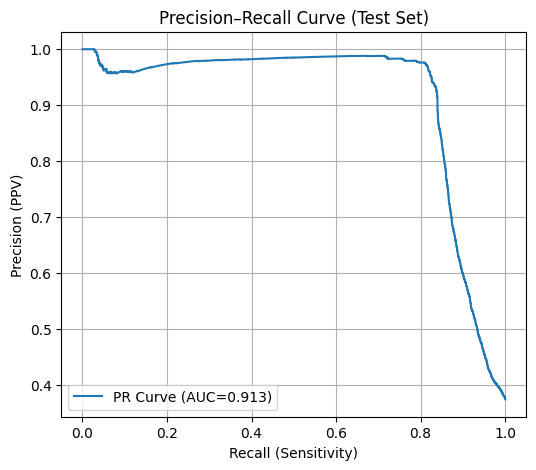


⚙️ Optimal probability threshold (max F1): 0.730

📊 Evaluation on Test Set (Optimized Threshold):
  Accuracy : 0.9217
  Precision: 0.9708
  Recall   : 0.8157
  F1 Score : 0.8865
  ROC AUC  : 0.9157


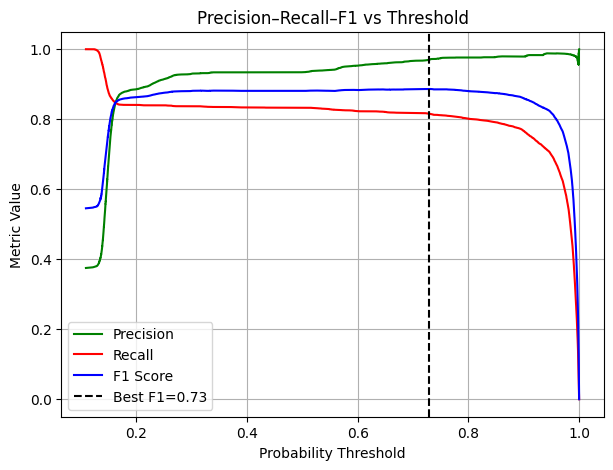

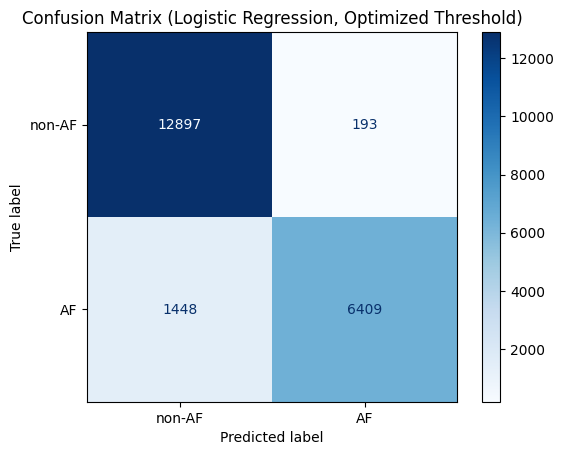

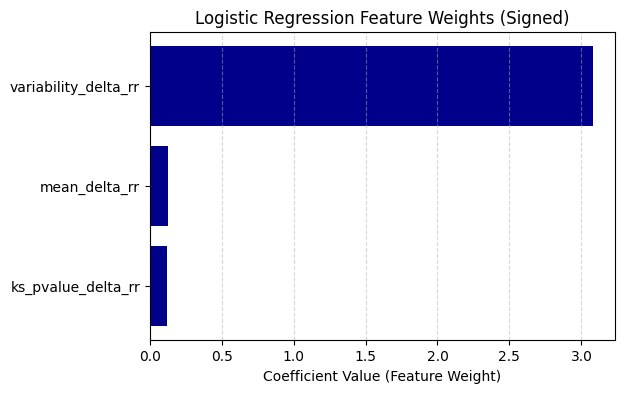

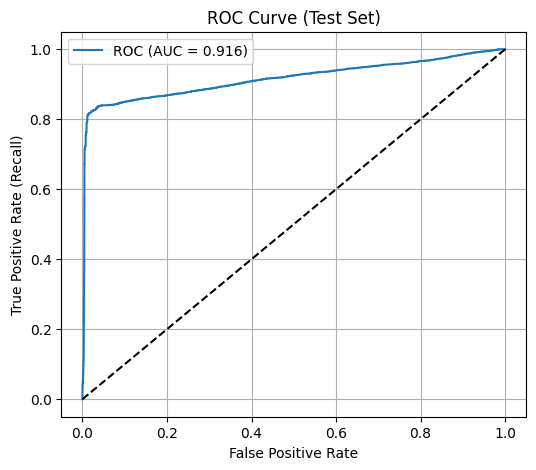

In [ ]:
# ============================================================
# ⚡ Logistic Regression (Linear Model) for AF Detection
# NO Task here - just try to understand the code and execute it.
# ============================================================
import xgboost as xgb # Retaining for comparison if needed
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ⚠️ NEW IMPORT: Logistic Regression
from sklearn.linear_model import LogisticRegression

# --- Placeholder for Data and Imbalance ---
# X_train_scaled, y_train, X_test_scaled, y_test are assumed to be defined globally.
# For Logistic Regression, class imbalance is handled via class_weight.

# ============================================================
# ⚙️ Step 1 — Hyperparameter grid (Tuned for Logistic Regression)
# ============================================================
# The main hyperparameter for Logistic Regression with L2 penalty is 'C'.
# C is the inverse of regularization strength (smaller C means stronger regularization).
param_dist = {
    # C is generally searched on a log scale (e.g., 0.001 to 1000)
    'C': Real(1e-3, 1e3, prior='log-uniform')
}

# ⚠️ Model Setup: Logistic Regression
log_reg_base = LogisticRegression(
    penalty='l2',                     # Use L2 regularization
    solver='liblinear',               # Good solver for small datasets
    class_weight='balanced',          # CRITICAL: Handle class imbalance
    random_state=42,
    n_jobs=-1,
)

# ⚠️ Using BayesSearchCV
grid = BayesSearchCV(
    log_reg_base,
    search_spaces=param_dist,
    n_iter=5,                      # Linear models need fewer iterations than tree models
    cv=3,                           # Use 5-fold CV for more stable estimation
    scoring='roc_auc',                   # Optimize directly for F1 Score
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True,
)

print("\n⏳ Running Bayesian Search for Logistic Regression...")
# Note: X_train_scaled and y_train are assumed to be defined globally
# No need for early stopping setup here as LR is not sequential like XGBoost
grid.fit(X_train_scaled, y_train)
print("✅ Bayesian Search complete.")

# ============================================================
# 🏆 Step 2 — Train with best parameters
# ============================================================
best_params = grid.best_params_
print(f"\n🏆 Best parameters from cross-validation:")
for k, v in best_params.items():
    # C parameter often comes back as 'C_inv' or similar from skopt, adjusting key for clarity
    print(f"  C                  : {v}")

# Train the final classifier on the full training set
log_reg_clf = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    C=best_params['C'] # Pass the best C value
)
log_reg_clf.fit(X_train_scaled, y_train)

# ============================================================
# 🔍 Step 3 — Predictions & probabilities
# ============================================================
y_pred_train  = log_reg_clf.predict(X_train_scaled)
# Logistic Regression uses predict_proba to get probabilities
y_proba_train = log_reg_clf.predict_proba(X_train_scaled)[:, 1]

y_pred_test  = log_reg_clf.predict(X_test_scaled)
y_proba_test = log_reg_clf.predict_proba(X_test_scaled)[:, 1]

# ============================================================
# 📊 Step 4 — Evaluation helper
# ============================================================
def evaluate_model(y_true, y_pred, y_proba, label="Set"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    print(f"\n📊 Evaluation on {label}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  ROC AUC  : {auc_roc:.4f}")
    return acc, prec, rec, f1, auc_roc

# --- Evaluate both training & test performance ---
evaluate_model(y_train, y_pred_train, y_proba_train, "Training Set (Threshold=0.5)")
evaluate_model(y_test,  y_pred_test,  y_proba_test,  "Test Set (Threshold=0.5)")

# ============================================================
# 🩸 Step 5 — Precision–Recall curve & threshold tuning
# ============================================================
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
pr_auc = auc(recalls, precisions)

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve (Test Set)")
plt.grid(True)
plt.legend()
plt.show()

# --- Find optimal threshold for maximum F1 ---
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\n⚙️ Optimal probability threshold (max F1): {best_thresh:.3f}")

# --- Apply optimized threshold ---
y_pred_opt = (y_proba_test >= best_thresh).astype(int)
evaluate_model(y_test, y_pred_opt, y_proba_test, "Test Set (Optimized Threshold)")

# ============================================================
# 📈 Step 6 — Precision, Recall, and F1 vs Threshold
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(thresholds, precisions[:-1], label="Precision", color="green")
plt.plot(thresholds, recalls[:-1], label="Recall", color="red")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="blue")
plt.axvline(best_thresh, color='black', linestyle='--', label=f"Best F1={best_thresh:.2f}")
plt.xlabel("Probability Threshold")
plt.ylabel("Metric Value")
plt.title("Precision–Recall–F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# Step 7 — Confusion Matrix (Optimized Threshold)
# ============================================================
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-AF', 'AF'])
disp.plot(cmap='Blues', values_format='d') # Changed cmap for visual difference
plt.title("Confusion Matrix (Logistic Regression, Optimized Threshold)")
plt.grid(False)
plt.show()

# ============================================================
# 🧠 Step 8 — Feature Importance (Logistic Regression specific)
# ============================================================
# For Logistic Regression, feature importance is represented by the coefficients.
feature_names = ["mean_delta_rr", "variability_delta_rr", "ks_pvalue_delta_rr"]
coefficients = log_reg_clf.coef_[0]

# Prepare data for plotting (using absolute value for comparison magnitude)
importance_df = pd.DataFrame(
    {'feature': feature_names, 'coefficient': coefficients, 'magnitude': np.abs(coefficients)}
).sort_values(by='magnitude', ascending=True)

plt.figure(figsize=(6, 4))
plt.barh(importance_df['feature'], importance_df['coefficient'],
         color=[('darkred' if c < 0 else 'darkblue') for c in importance_df['coefficient']])
plt.xlabel("Coefficient Value (Feature Weight)")
plt.title("Logistic Regression Feature Weights (Signed)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

# ============================================================
# 🩺 Step 9 — ROC Curve
# ============================================================
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba_test):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



## 🔍 Visualizing Errors - 2D Feature Projections

To better understand our model's mistakes, we'll perform **error analysis**.  
Since our feature space is small (just 3 features), we can **easily visualize it in 2D**.

We define a reusable function that plots the **misclassified samples** across all 3 pairs of features.  
This helps us identify patterns in errors and see how well-separated the classes are under different projections.

We'll use this for different classifiers later.


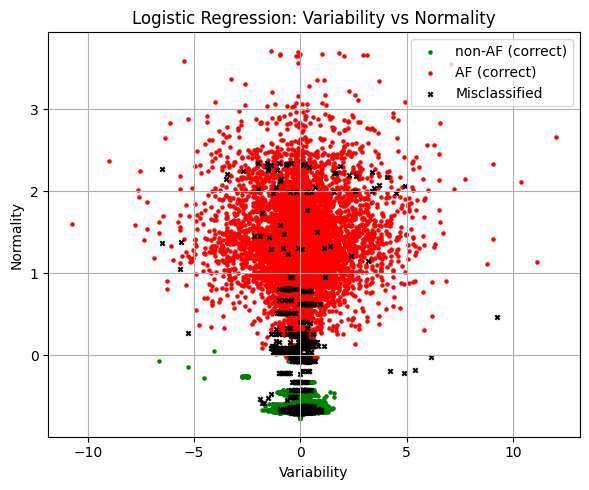

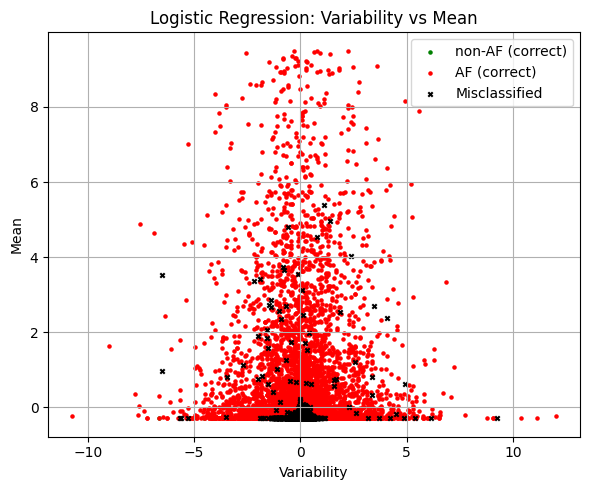

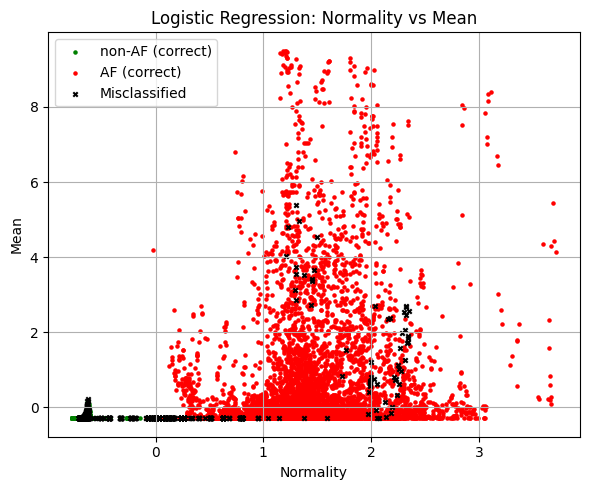

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_misclassified_2D(X_test_scaled, y_test, y_pred, title_prefix):
    """
    Plots misclassified points in 2D feature spaces (all feature pairs).

    Args:
        X_test_scaled: np.ndarray, shape (n_samples, 3)
        y_test: true labels (binary)
        y_pred: predicted labels (binary)
        title_prefix: str to prefix each plot title (e.g., "LogReg", "Tree")
    """
    feature_names = ["Variability", "Normality", "Mean"]
    pairs = [(0, 1), (0, 2), (1, 2)]
    misclassified = y_test != y_pred

    for i, j in pairs:
        plt.figure(figsize=(6, 5))

        # Correct predictions
        plt.scatter(X_test_scaled[(y_test == 0) & ~misclassified, i],
                    X_test_scaled[(y_test == 0) & ~misclassified, j],
                    c='green', s=5, label='non-AF (correct)')

        plt.scatter(X_test_scaled[(y_test == 1) & ~misclassified, i],
                    X_test_scaled[(y_test == 1) & ~misclassified, j],
                    c='red', s=5, label='AF (correct)')

        # Misclassified points
        plt.scatter(X_test_scaled[misclassified, i],
                    X_test_scaled[misclassified, j],
                    c='black', s=10, label='Misclassified', marker='x')

        plt.xlabel(feature_names[i])
        plt.ylabel(feature_names[j])
        plt.title(f"{title_prefix}: {feature_names[i]} vs {feature_names[j]}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_misclassified_2D(X_test_scaled, y_test, y_pred_test, "Logistic Regression")


## 🧩  TASK 5 - Interpretation of error analysis (0.5 + 0.5 + 1 points)

Inspect the three plots showing misclassified ECG windows for the Logistic Regression model:
Variability vs Normality
Variability vs Mean
Normality vs Mean

Answer the following:


1.   In which regions of the feature space do most misclassifications occur? Describe their location relative to the two classes.
2.   Which feature appears to dominate the decision of the logistic regression model?
Which feature seems less influential?

3.   Why is a linear classifier likely to struggle with these data, based on the plots?
Give one plausible signal-processing or physiological explanation.



## 🧩  TASK 5 - YOUR ANSWERS

Short answers (2–4 sentences per question) are sufficient.

1.   Die meisten Falschklassifizierung wurden für Windows mit  Variability nahe 0, Normalität gegen 0 oder noch niedriger (Peak um ein Wert), sowie für ein mean von ungefähr -0.6. Meisten Falschklassifizierung in dem bereich der eigentlich kein AF hat.
2.  Variabilität domninant (ersten beiden Plots), trotz Trennung nach Normalität viele falsch klassifizierungen. Dritter Plot, trennung nach Normalität möglich, => Mean dominiert
3.  Prozesse überlappen, nicht immer gut trennbar durch Linie, einige Ausreißer=> nicht gut durch linearen Klassifizierer trennbar.
Signal-Processing: Features können normale Inkonstanz von Herzschlägen, oder zufällige passende Rythmenn nicht beschreiben. Demnach wird falsch klassifiziert.
Physiologisch: AF führt zu unregelmäßigen Herzschlag. Dieser ist aber nicht konstant unregelmäsig sonder kann auch in Phasen eintreten oder in verschieden Stärken. Normaler Rythmus kann stark beeinflusst werden durch Bewegung oder Stress.








## 🌳 Let's move on to a non-linear model

Next we'll train and evaluate the gradient boosting model XGBoost.

scale_pos_weight = 1.665945464380031

⏳ Running Bayesian Search for XGBoost...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candid

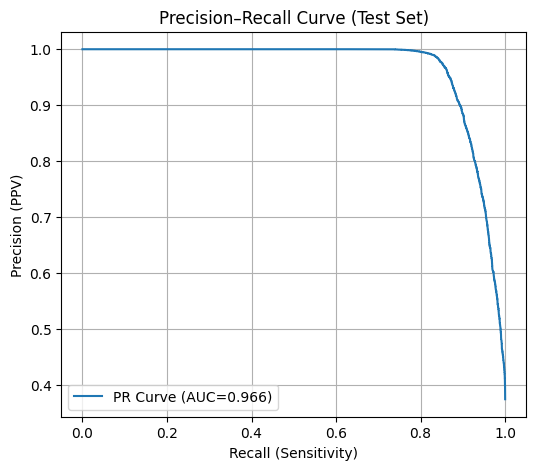


⚙️ Optimal probability threshold (max F1): 0.467

📊 Evaluation on Test Set (Optimized Threshold):
  Accuracy : 0.9362
  Precision: 0.9662
  Recall   : 0.8599
  F1 Score : 0.9100
  ROC AUC  : 0.9686


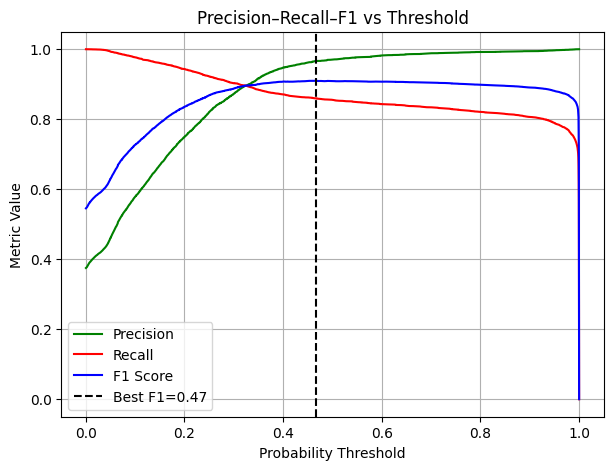

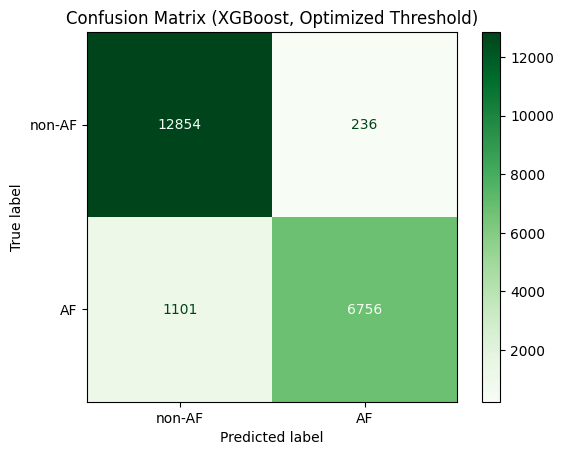

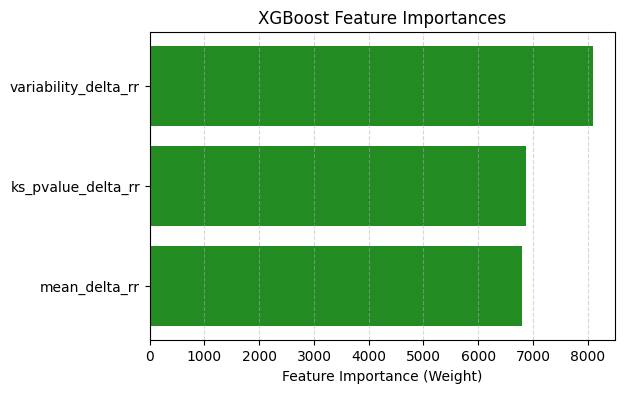

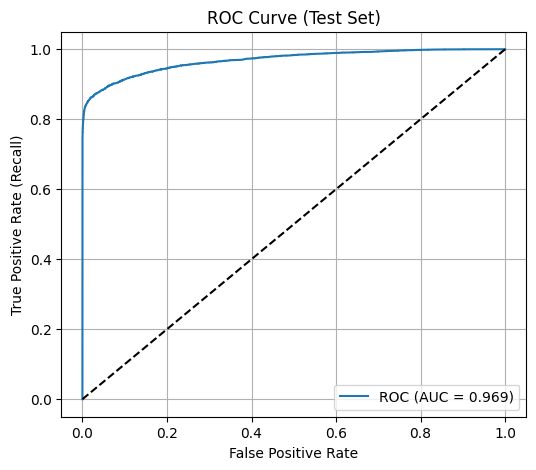

In [ ]:
# ============================================================
# ⚡ XGBoost for AF Detection — Full Training Evaluation
# Here, you will find the BONUS Task:
# 🧩 BONUS Task — Calculate imbalance ratio from the training data (1 point)
# ============================================================
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# 🧩 BONUS Task — Calculate imbalance ratio from the training data
# Hint: ratio = (# of non-AF samples) / (# of AF samples)
num_af = np.sum(y_train == 1)
num_non_af = np.sum(y_train == 0)

SCALE_POS_WEIGHT_RATIO = num_non_af / num_af
print(f"scale_pos_weight = {SCALE_POS_WEIGHT_RATIO}")

# ============================================================
# ⚙️ Step 1 — Hyperparameter grid (Tuned for XGBoost)
# ============================================================
# Define the search space using skopt space objects for common XGBoost parameters
param_dist = {
    # Increase the range for boosting rounds (trees) to allow for lower learning rates
    'n_estimators': Integer(200, 1000),

    # Tighten max_depth: boosting trees are usually shallow for better generalization
    'max_depth': Integer(3, 8),

    # CRITICAL: Widen learning rate range for better exploration
    'learning_rate': Real(0.005, 0.5, prior='log-uniform'),

    # regularization terms (kept wide to allow BayesSearchCV to find optimal point)
    'reg_alpha': Real(1e-5, 100, prior='log-uniform'),
    'reg_lambda': Real(1e-5, 100, prior='log-uniform'),

    # Minimum loss reduction required to make a further partition on a leaf node
    'gamma': Real(1e-5, 1.0, prior='log-uniform'),

    # Minimum sum of instance weight (Hessian) needed in a child
    'min_child_weight': Integer(1, 15), # Increased upper bound slightly

    # Subsample ratio of columns when constructing each tree
    'colsample_bytree': Real(0.5, 1.0, prior='uniform')
}

# Using XGBClassifier (objective='binary:logistic' for probability)
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=SCALE_POS_WEIGHT_RATIO, # Handle class imbalance
    eval_metric='logloss',                   # Metric for evaluation
    use_label_encoder=False,                 # Required for newer XGBoost versions
    random_state=42,
    n_jobs=-1,
    verbosity=0                              # Suppress internal messages
)

# Using BayesSearchCV with XGBoost
grid = BayesSearchCV(
    xgb_base,
    search_spaces=param_dist,
    n_iter=50,                      # INCREASED ITERATIONS to 50 for more thorough search
    cv=3,                           # 3-fold CV
    scoring='roc_auc',                   # CRITICAL CHANGE: Optimize directly for F1 Score
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True,
)

print("\n⏳ Running Bayesian Search for XGBoost...")
# Note: X_train_scaled and y_train are assumed to be defined globally
grid.fit(X_train_scaled, y_train)
print("✅ Bayesian Search complete.")

# ============================================================
# 🏆 Step 2 — Train with best parameters
# ============================================================
best_params = grid.best_params_
print(f"\n🏆 Best parameters from cross-validation:")
for k, v in best_params.items():
    print(f"  {k:<20}: {v}")

# Train the final classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=SCALE_POS_WEIGHT_RATIO,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    **best_params
)
xgb_clf.fit(X_train_scaled, y_train)

# ============================================================
# 🔍 Step 3 — Predictions & probabilities
# ============================================================
y_pred_train  = xgb_clf.predict(X_train_scaled)
# XGBoost uses predict_proba to get probabilities
y_proba_train = xgb_clf.predict_proba(X_train_scaled)[:, 1]

y_pred_test  = xgb_clf.predict(X_test_scaled)
y_proba_test = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# ============================================================
# 📊 Step 4 — Evaluation helper (no change needed)
# ============================================================
def evaluate_model(y_true, y_pred, y_proba, label="Set"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    print(f"\n📊 Evaluation on {label}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  ROC AUC  : {auc_roc:.4f}")
    return acc, prec, rec, f1, auc_roc

# --- Evaluate both training & test performance ---
evaluate_model(y_train, y_pred_train, y_proba_train, "Training Set (Threshold=0.5)")
evaluate_model(y_test,  y_pred_test,  y_proba_test,  "Test Set (Threshold=0.5)")

# ============================================================
# 🩸 Step 5 — Precision–Recall curve & threshold tuning (no change needed)
# ============================================================
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
pr_auc = auc(recalls, precisions)

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve (Test Set)")
plt.grid(True)
plt.legend()
plt.show()

# --- Find optimal threshold for maximum F1 ---
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\n⚙️ Optimal probability threshold (max F1): {best_thresh:.3f}")

# --- Apply optimized threshold ---
y_pred_opt = (y_proba_test >= best_thresh).astype(int)
evaluate_model(y_test, y_pred_opt, y_proba_test, "Test Set (Optimized Threshold)")

# ============================================================
# 📈 Step 6 — Precision, Recall, and F1 vs Threshold
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(thresholds, precisions[:-1], label="Precision", color="green")
plt.plot(thresholds, recalls[:-1], label="Recall", color="red")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="blue")
plt.axvline(best_thresh, color='black', linestyle='--', label=f"Best F1={best_thresh:.2f}")
plt.xlabel("Probability Threshold")
plt.ylabel("Metric Value")
plt.title("Precision–Recall–F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 🧩 Step 7 — Confusion Matrix (Optimized Threshold)
# ============================================================
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-AF', 'AF'])
disp.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix (XGBoost, Optimized Threshold)")
plt.grid(False)
plt.show()

# ============================================================
# 🧠 Step 8 — Feature Importance (XGBoost specific)
# ============================================================
# ⚠️ CHANGE 4: Adapted to use XGBoost's specific feature importance score
importances = xgb_clf.get_booster().get_score(importance_type='weight')
feature_names = ["mean_delta_rr", "variability_delta_rr", "ks_pvalue_delta_rr"]

# Prepare data for plotting
importance_df = pd.DataFrame(
    {'feature': feature_names, 'importance': [importances.get(f'f{i}', 0) for i in range(len(feature_names))]}
).sort_values(by='importance', ascending=True)

plt.figure(figsize=(6, 4))
plt.barh(importance_df['feature'], importance_df['importance'], color='forestgreen')
plt.xlabel("Feature Importance (Weight)")
plt.title("XGBoost Feature Importances")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

# ============================================================
# 🩺 Step 9 — ROC Curve
# ============================================================
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba_test):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


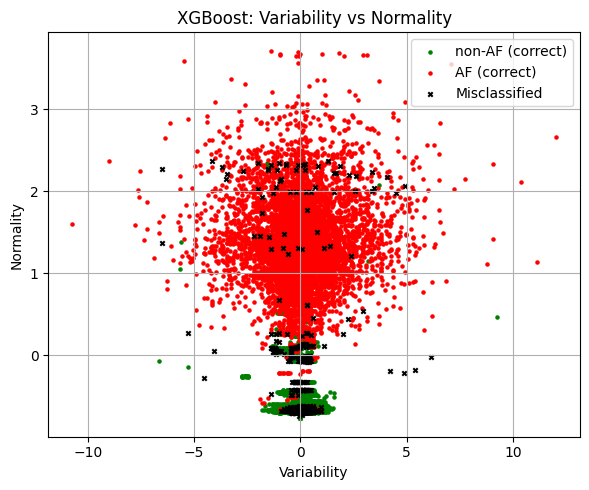

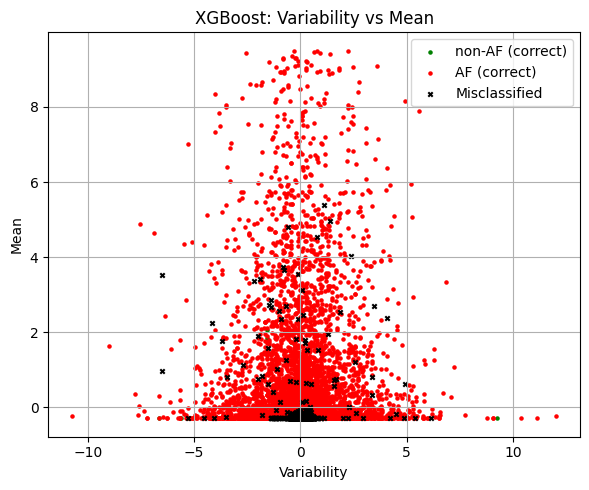

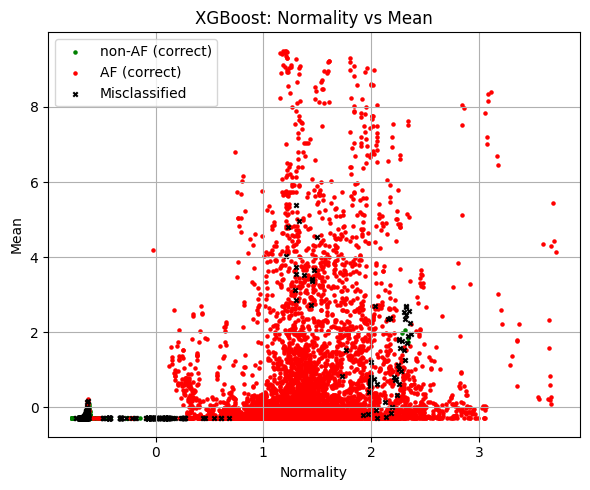

In [ ]:
plot_misclassified_2D(X_test_scaled, y_test, y_pred_test, "XGBoost")


## 🏁 Conclusion - Part 1

In this notebook, we demonstrated a full pipeline for atrial fibrillation (AF) detection from ECG signals using interpretable features. Specifically:

- We extracted three features from RR interval differences – variability, normality, and mean – to capture the irregular heartbeat patterns characteristic of AF.
- We trained and evaluated two classifiers:
  - Logistic Regression – applied with regularization, and tuned using grid search with cross-validation to select the best parameters.
  - XGBoost – which outperformed logistic regression by capturing non-linear relations in the feature space.
- We emphasized the importance of feature scaling and avoiding data leakage by fitting the scaler only on the training set.
- We also included error visualization in 2D feature spaces to better understand where and why models make mistakes.

This shows that even simple, well-crafted features can be powerful for AF detection from ECG data.

# Part 2 - Forecasting ECG Recordings  

---

**Repetition: What is an ECG?**  
An electrocardiogram is a voltage trace captured by electrodes on the skin. Each heartbeat follows a characteristic sequence:

* **P-wave** – depolarisation of the atria, leading to atrial contraction.  
* **QRS complex** – rapid depolarisation and contraction of the ventricles.  
* **T-wave** – ventricular repolarisation as the heart resets and the ventricles relax for the next beat.

**Time series forecasting** in the context of ECG involves predicting future segments of the signal based on its recent history. This can help estimate how the heart rhythm will evolve in the next few milliseconds or beats. Such forecasting is valuable for early detection of arrhythmias, anticipating signal anomalies, or supporting real-time monitoring systems that can alert clinicians to irregular patterns before they fully manifest. Because ECGs are highly periodic yet sensitive to small physiological changes, forecasting models must learn both short-term dependencies within individual beats and long-term variations across heart cycles.

In our experimental setup, we will **train** our models on ECG recordings from **patient 42**, and **validate** our forecasts using recordings from **patient 11**.

This is a very **simplified setup** that will yield somewhat subpar results, acknowledging that we don't want to spend too much time waiting for models to train as well as the limited resources available in our Colab notebooks.




In [4]:
# --- Download an exemplary short ECG records from PhysioNet ---
!mkdir -p data
import wfdb

DB_NAME  = "ltafdb"
RECORDS  = ["42", "11"]   # 42 = train, 11 = test

for rec in RECORDS:
    rec_path = f"data/{rec}.hea"
    if os.path.exists(rec_path):
        print(f"✅ Record {rec} already exists in data/, skipping download.")
        continue

    print(f"Downloading record {rec} from {DB_NAME} ...")
    wfdb.dl_database(
        DB_NAME,
        records=[rec],
        dl_dir="data",
        keep_subdirs=False,   # puts 42.dat / 42.hea directly into data/
    )

print("\n✅ Download complete. Files in /data:")
!ls -lh data | head

Generating record list for: 42
Generating list of all files for: 42
Finished downloading files
Generating record list for: 11
Generating list of all files for: 11
Finished downloading files

✅ Download complete. Files in /data:
total 84M
-rw-r--r-- 1 root root 201K Jan 14 08:52 11.atr
-rw-r--r-- 1 root root  47M Jan 14 08:52 11.dat
-rw-r--r-- 1 root root  119 Jan 14 08:49 11.hea
-rw-r--r-- 1 root root 201K Jan 14 08:52 11.qrs
-rw-r--r-- 1 root root 226K Jan 14 08:49 42.atr
-rw-r--r-- 1 root root  38M Jan 14 08:49 42.dat
-rw-r--r-- 1 root root  118 Jan 14 08:47 42.hea
-rw-r--r-- 1 root root 226K Jan 14 08:49 42.qrs


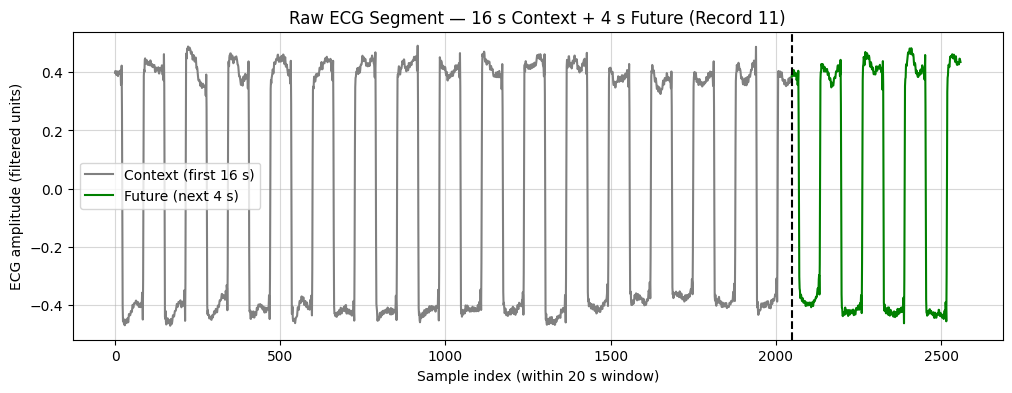

In [5]:
# This time, we will work with the cleaned ECG data.
# Let's start by visualizing an exemplary segment.

# ============================================================
# 📈 Visualize an exemplary RAW ECG segment (16s context + 4s future)
# ============================================================



import numpy as np
import wfdb
from scipy import signal
import matplotlib.pyplot as plt

# --- Config for this demo plot ---
CONTEXT_SECONDS   = 16.0    # context length
FORECAST_SECONDS  = 4.0     # future length
LEAD_INDEX        = 0
LOWCUT, HIGHCUT   = 0.5, 40.0
FILTER_ORDER      = 3

def butter_bandpass(sig, fs, low=LOWCUT, high=HIGHCUT, order=FILTER_ORDER):
    nyq = 0.5 * fs
    low_norm = max(0.001, low / nyq)
    high_norm = min(0.999, high / nyq)
    b, a = signal.butter(order, [low_norm, high_norm], btype='band')
    sig_f = signal.filtfilt(b, a, sig)
    return sig_f

def load_filtered_ecg(record_path, lead_index=LEAD_INDEX, use_filter=True):
    """Load a record and return (ecg, fs)."""
    rec = wfdb.rdrecord(record_path)
    fs = rec.fs
    sig = rec.p_signal[:, lead_index].astype(float)
    if use_filter:
        sig = butter_bandpass(sig, fs)
    return sig, fs

# --- Load an exemplary ECG record (e.g., data/42 from ltafdb) ---
#ecg, fs = load_filtered_ecg("data/42", use_filter=True)  # set False if you want truly raw
ecg, fs = load_filtered_ecg("data/11", use_filter=True)

context_samples  = int(CONTEXT_SECONDS * fs)
forecast_samples = int(FORECAST_SECONDS * fs)
window_samples   = context_samples + forecast_samples

if len(ecg) < window_samples:
    raise RuntimeError(
        f"ECG too short ({len(ecg)} samples) for a {window_samples}-sample window."
    )

# Take a segment from the middle of the recording
start = len(ecg) // 160 - window_samples // 160
start = max(start, 0)
segment = ecg[start:start + window_samples]

context = segment[:context_samples]
future  = segment[context_samples:]

# --- Plot: 20s context + 4s future (no forecast) ---
plt.figure(figsize=(12, 4))
plt.plot(range(context_samples), context, color="gray", label="Context (first 16 s)")
plt.plot(
    range(context_samples, context_samples + forecast_samples),
    future,
    color="green",
    label="Future (next 4 s)",
)
plt.axvline(context_samples, color="black", linestyle="--")
plt.xlabel("Sample index (within 20 s window)")
plt.ylabel("ECG amplitude (filtered units)")
plt.title("Raw ECG Segment — 16 s Context + 4 s Future (Record 11)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()





---


The plot shows a 20-second segment of raw ECG from **record 11** after basic band-pass filtering.  
The signal is split into:

- **Context (first 16 s, grey)** – this is the input that forecasting models will see.  
  It contains a sequence of nearly periodic heart beats with fairly regular morphology and
  amplitude, typical for long stretches of atrial fibrillation in this record.

- **Future (next 4 s, green)** – this is the target segment we want the model to predict.
  It continues the same rhythm and morphology as the context, but is hidden from the
  forecaster during inference.

The vertical dashed line marks the **boundary between context and forecast horizon**.  
All subsequent models are trained or evaluated
on windows with exactly this structure: the first 16 seconds as input and the following
4 seconds as the prediction target.```
::contentReference[oaicite:0]{index=0}


---



## 🧰 Let's start forecasting using PatchTST

As explained in the lecture, **PatchTST (Patch Time Series Transformer)** is a Transformer-based architecture specifically designed for long-term forecasting of (multivariate) time series. It has demonstrated state-of-the-art performance by introducing two key innovations to adapt the powerful Transformer model—originally popularized in Natural Language Processing—for time series data:

**Patching (Segmentation of Time Series)**

Instead of treating individual time steps as input tokens (like words in a sentence, which is known as point-wise attention), PatchTST segments each time series into subseries-level "patches" (short, fixed-length segments).


These patches become the input tokens for the Transformer encoder. This is highly effective because:


*   It retains local semantic information (patterns within the short patch).

*   It significantly reduces computational complexity and memory usage, allowing the model to process much longer historical sequences.

**Channel-Independence**

For multivariate time series (data with multiple features or "channels," like temperature, wind speed, and humidity), PatchTST processes each individual time series (channel) independently using the same shared Transformer backbone and weights.

This approach simplifies the modeling of complex multi-channel data, improves training efficiency, and enhances the model's ability to generalize across different channels. The final predictions are then generated for each channel and combined.


---

Useful links



*   Github: https://github.com/yuqinie98/PatchTST
*   Paper: Nie et al. 2023, arXiv:2211.14730




✅ data/42: 600 windows of 2560 samples each (fs=128 Hz)
Context samples: 2048, Forecast samples: 512
X shape: (600, 2048), Y shape: (600, 512)
✅ data/11: 200 windows of 2560 samples each (fs=128 Hz)
Context samples: 2048, Forecast samples: 512
X shape: (200, 2048), Y shape: (200, 512)

Final RAW ECG shapes:
  TRAIN (42): X=(600, 2048), Y=(600, 512)
  TEST  (11): X=(200, 2048),     Y=(200, 512)
Device: cpu

From record 42 (RAW ECG):
  Train core windows: 540
  Val windows       : 60
From record 11 (RAW ECG):
  Test windows      : 200

Starting PatchTST training on RAW ECG from record 42...
Epoch 1/10 | Train: 51.9436 | Val: 17.8815 | NoImprove: 0/5
Epoch 2/10 | Train: 14.9153 | Val: 11.6914 | NoImprove: 0/5
Epoch 3/10 | Train: 10.7058 | Val: 11.1265 | NoImprove: 0/5
Epoch 4/10 | Train: 7.4682 | Val: 7.0824 | NoImprove: 0/5
Epoch 5/10 | Train: 6.8339 | Val: 5.7572 | NoImprove: 0/5
Epoch 6/10 | Train: 5.3568 | Val: 4.6611 | NoImprove: 0/5
Epoch 7/10 | Train: 4.1783 | Val: 4.2041 | NoImpro

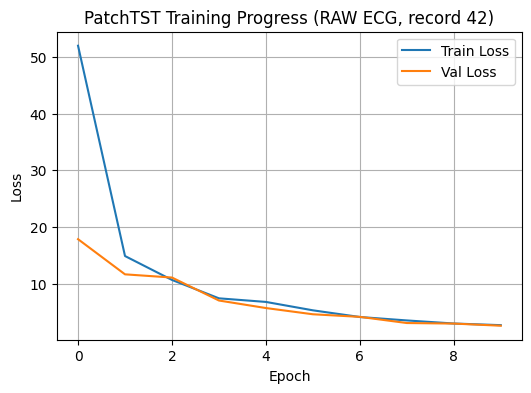


===== PatchTST Test Performance (RAW ECG, record 11) =====
Scaled   → MSE: 1.345886, MAE: 0.759919, sMAPE: 135.24%
Original → MSE: 0.064524, MAE: 0.166388, sMAPE: 135.23%

Plotting test sample index: 3 of 200 (record 11)


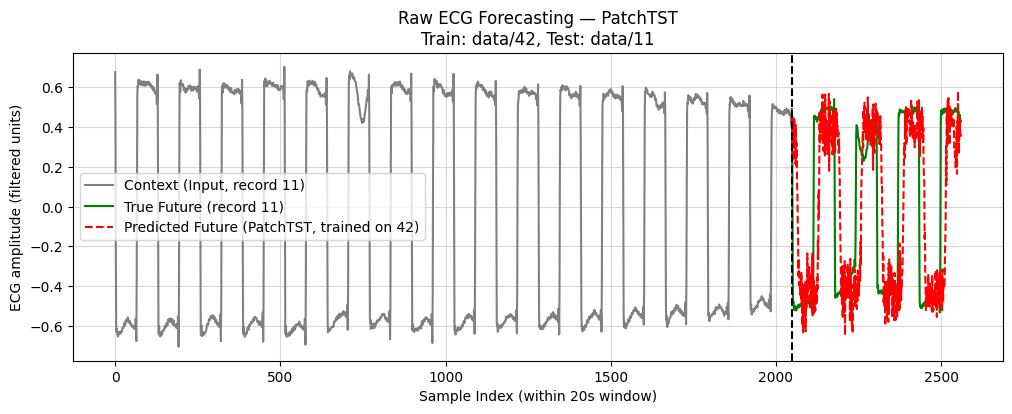

In [6]:
# ============================================================
# ⚡ Raw ECG Forecasting with PatchTST
# Train on data/42, Test on data/11
# NO Task here - try to understand the code and execute it.
# ============================================================

import numpy as np
import wfdb
from scipy import signal
from wfdb import processing as wfproc
import matplotlib.pyplot as plt
import random

# ---------------------- Global Seeds -------------------------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# --- Configuration for RAW ECG (in samples) ---
WINDOW_SECONDS   = 20.0     # total window length (e.g. 20s)
CONTEXT_RATIO    = 0.8      # 80% context, 20% forecast
WINDOW_STEP_SEC  = WINDOW_SECONDS  # non-overlapping windows

LEAD_INDEX = 0
LOWCUT, HIGHCUT = 0.5, 40.0
FILTER_ORDER = 3

MAX_WINDOWS_PER_RECORD = 2000   # safety cap per record
MAX_TRAIN_WINDOWS      = 600    # from record 42
MAX_TEST_WINDOWS       = 200    # from record 11

# PatchTST hyperparams (in *sample* domain now)
PATCH_LEN    = 128
PATCH_STRIDE = 16
D_MODEL      = 128
N_HEADS      = 4
N_LAYERS     = 4
D_FF         = 256
DROPOUT      = 0.3

# ============================================================
# Preprocessing helpers (for raw ECG)
# ============================================================
def butter_bandpass(sig, fs, low=LOWCUT, high=HIGHCUT, order=FILTER_ORDER):
    nyq = 0.5 * fs
    low_norm = max(0.001, low / nyq)
    high_norm = min(0.999, high / nyq)
    b, a = signal.butter(order, [low_norm, high_norm], btype='band')
    sig_f = signal.filtfilt(b, a, sig)
    return sig_f

def process_record_ecg_windows(record_path,
                               window_seconds=WINDOW_SECONDS,
                               step_seconds=WINDOW_STEP_SEC,
                               max_windows=MAX_WINDOWS_PER_RECORD):
    """Return raw ECG windows (N, window_samples) for a single record."""
    try:
        rec = wfdb.rdrecord(record_path)
    except FileNotFoundError:
        raise RuntimeError(f"Cannot find record at {record_path}. Did you download it?")

    fs = rec.fs
    sig = rec.p_signal[:, LEAD_INDEX].astype(float)
    sig_f = butter_bandpass(sig, fs)

    window_samples = int(window_seconds * fs)
    step_samples   = int(step_seconds * fs)

    if len(sig_f) < window_samples:
        raise RuntimeError(
            f"Too few samples ({len(sig_f)}) for {window_samples}-sample windows in {record_path}"
        )

    windows = [
        sig_f[i:i + window_samples]
        for i in range(0, len(sig_f) - window_samples + 1, step_samples)
    ]
    windows = np.array(windows)

    if len(windows) > max_windows:
        windows = windows[:max_windows]

    print(f"✅ {record_path}: {len(windows)} windows of {window_samples} samples each (fs={fs} Hz)")
    return windows, fs, window_samples

def split_context_forecast_samples(windows, context_ratio=CONTEXT_RATIO):
    """Split sample windows into context and forecast parts."""
    window_samples = windows.shape[1]
    context_samples = int(window_samples * context_ratio)
    forecast_samples = window_samples - context_samples

    X = windows[:, :context_samples]
    Y = windows[:, context_samples:]
    print(f"Context samples: {context_samples}, Forecast samples: {forecast_samples}")
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y, context_samples, forecast_samples

# ============================================================
# Build TRAIN from data/42, TEST from data/11 (RAW ECG)
# ============================================================
try:
    # --- TRAIN: record 42 ---
    win_42, fs_42, window_samples_42 = process_record_ecg_windows(
        "data/42",
        window_seconds=WINDOW_SECONDS,
        step_seconds=WINDOW_STEP_SEC,
        max_windows=MAX_TRAIN_WINDOWS,
    )
    X_train_all, Y_train_all, CONTEXT_SAMPLES, FORECAST_SAMPLES = split_context_forecast_samples(
        win_42, context_ratio=CONTEXT_RATIO
    )

    # --- TEST: record 11 ---
    win_11, fs_11, window_samples_11 = process_record_ecg_windows(
        "data/11",
        window_seconds=WINDOW_SECONDS,
        step_seconds=WINDOW_STEP_SEC,
        max_windows=MAX_TEST_WINDOWS,
    )
    X_test, Y_test, CONTEXT_SAMPLES_test, FORECAST_SAMPLES_test = split_context_forecast_samples(
        win_11, context_ratio=CONTEXT_RATIO
    )

    if fs_42 != fs_11:
        print(f"⚠️ Warning: fs_42={fs_42} Hz, fs_11={fs_11} Hz (not identical).")
    if (CONTEXT_SAMPLES != CONTEXT_SAMPLES_test) or (FORECAST_SAMPLES != FORECAST_SAMPLES_test):
        raise RuntimeError("Context/forecast sample lengths differ between records 42 and 11.")

except Exception as e:
    print(f"❌ Error while building train/test from records 42 and 11 (raw ECG): {e}")
    raise SystemExit(1)

print(f"\nFinal RAW ECG shapes:")
print(f"  TRAIN (42): X={X_train_all.shape}, Y={Y_train_all.shape}")
print(f"  TEST  (11): X={X_test.shape},     Y={Y_test.shape}")

# ============================================================
# PatchTST model + training utilities (for raw ECG)
# ============================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

class ECGBaselineDataset(Dataset):
    def __init__(self, X_arr, y_arr):
        self.X = torch.tensor(X_arr, dtype=torch.float32)
        self.y = torch.tensor(y_arr, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PatchTST(nn.Module):
    def __init__(self,
                 input_dim=1,
                 context_len=None,
                 forecast_len=None,
                 patch_len=PATCH_LEN,
                 stride=PATCH_STRIDE,
                 d_model=D_MODEL,
                 n_heads=N_HEADS,
                 num_layers=N_LAYERS,
                 d_ff=D_FF,
                 dropout=DROPOUT):
        super().__init__()

        if context_len is None or forecast_len is None:
            raise ValueError("Please pass context_len and forecast_len when creating PatchTST.")

        self.context_len = context_len
        self.forecast_len = forecast_len
        self.patch_len = patch_len
        self.stride = stride
        self.input_dim = input_dim

        # number of patches along the time dimension
        self.n_patches = 1 + (context_len - patch_len) // stride
        if self.n_patches <= 0:
            raise ValueError("context_len must be >= patch_len")

        # Each patch is (patch_len, input_dim) flattened → patch_len * input_dim
        patch_dim = patch_len * input_dim
        self.patch_proj = nn.Linear(patch_dim, d_model)

        # Positional embedding over patches
        self.pos_emb = nn.Parameter(torch.zeros(1, self.n_patches, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(d_model * self.n_patches)
        self.head = nn.Linear(d_model * self.n_patches, forecast_len)

    def _patchify(self, x):
        """
        x: (batch, seq_len, input_dim)
        returns: (batch, n_patches, patch_len * input_dim)
        """
        # Unfold along the time dimension (dim=1) into overlapping patches
        # patches: (batch, n_patches, patch_len, input_dim)
        patches = x.unfold(dimension=1, size=self.patch_len, step=self.stride)

        # In case rounding makes more patches than expected, trim to self.n_patches
        patches = patches[:, :self.n_patches, :, :]

        b, n_p, p_l, c = patches.shape  # n_p should == self.n_patches, p_l == patch_len, c == input_dim

        # Flatten (patch_len, input_dim) into a single feature dimension
        patches = patches.contiguous().view(b, n_p, p_l * c)  # (batch, n_patches, patch_len * input_dim)
        return patches

    def forward(self, src):
        """
        src: (batch, context_len) for univariate
             or (batch, context_len, input_dim) if you later go multivariate.
        """
        if src.dim() == 2:
            # univariate: (B, L) → (B, L, 1)
            x = src.unsqueeze(-1)
        else:
            # already (B, L, C)
            x = src

        # (batch, n_patches, patch_len * input_dim)
        patches = self._patchify(x)

        # Project patches to d_model
        # (batch, n_patches, d_model)
        tokens = self.patch_proj(patches)

        # Add patch-wise positional embedding
        tokens = tokens + self.pos_emb

        # Transformer encoder over patch tokens
        # (batch, n_patches, d_model)
        enc_out = self.encoder(tokens)

        # Flatten all patch embeddings
        flat = enc_out.reshape(enc_out.size(0), -1)   # (batch, n_patches * d_model)
        flat = self.norm(flat)

        # Final head to forecast the full horizon
        y = self.head(flat)                           # (batch, forecast_len)
        return y


mae = nn.L1Loss()
mse = nn.MSELoss()
LAMBDA_SMOOTH = 3  # a bit smaller for ECG than RR, tweak as needed

def loss_fn(pred, target, lambda_smooth=LAMBDA_SMOOTH):
    # base loss
    base = mae(pred, target) + 0.5 * mse(pred, target)
    # smoothness penalty on forecast differences
    diff = pred[:, 1:] - pred[:, :-1]
    smooth = torch.mean(diff ** 2)
    return base + lambda_smooth * smooth

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_true - y_pred) / denom)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ============================================================
# Train / Val split on record 42 ONLY (no leakage from 11)
# ============================================================
n_train_all = len(X_train_all)
n_train_core = int(0.9 * n_train_all)   # 90% for train, 10% for val

X_train = X_train_all[:n_train_core]
Y_train = Y_train_all[:n_train_core]
X_val   = X_train_all[n_train_core:]
Y_val   = Y_train_all[n_train_core:]

print(f"\nFrom record 42 (RAW ECG):")
print(f"  Train core windows: {len(X_train)}")
print(f"  Val windows       : {len(X_val)}")

print(f"From record 11 (RAW ECG):")
print(f"  Test windows      : {len(X_test)}")

# --- Fit scaler ONLY on training context from record 42 ---
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, 1))

X_train_scaled = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

Y_train_scaled = scaler.transform(Y_train.reshape(-1, 1)).reshape(Y_train.shape)
Y_val_scaled   = scaler.transform(Y_val.reshape(-1, 1)).reshape(Y_val.shape)
Y_test_scaled  = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)

train_dataset = ECGBaselineDataset(X_train_scaled, Y_train_scaled)
val_dataset   = ECGBaselineDataset(X_val_scaled,   Y_val_scaled)
test_dataset  = ECGBaselineDataset(X_test_scaled,  Y_test_scaled)

BATCH_SIZE = 32
EPOCHS     = 10
PATIENCE   = 5

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# ============================================================
# Train PatchTST with early stopping on validation (record 42)
# ============================================================
model = PatchTST(
    context_len=CONTEXT_SAMPLES,
    forecast_len=FORECAST_SAMPLES,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val = float('inf')
best_state = None
epochs_no_improve = 0

train_losses = []
val_losses   = []

print("\nStarting PatchTST training on RAW ECG from record 42...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train_loss += loss.item()
    avg_train = total_train_loss / len(train_loader)
    train_losses.append(avg_train)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            total_val_loss += loss_fn(y_pred, y_batch).item()
    avg_val = total_val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train: {avg_train:.4f} | Val: {avg_val:.4f} | "
        f"NoImprove: {epochs_no_improve}/{PATIENCE}"
    )

    if avg_val < best_val:
        best_val = avg_val
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("⏹ Early stopping.")
        break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"✅ Restored best model (Val Loss={best_val:.4f})")

# ============================================================
# Training curves
# ============================================================
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PatchTST Training Progress (RAW ECG, record 42)")
plt.legend()
plt.grid(True)
plt.show()



# ============================================================
# Evaluate on TEST set (record 11, RAW ECG)
# ============================================================
model.eval()
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_pred_test.append(y_pred)
        y_true_test.append(y_batch.numpy())

y_true_test = np.concatenate(y_true_test, axis=0)
y_pred_test = np.concatenate(y_pred_test, axis=0)

# Scaled metrics
mse_scaled   = mean_squared_error(y_true_test.flatten(), y_pred_test.flatten())
mae_scaled   = mean_absolute_error(y_true_test.flatten(), y_pred_test.flatten())
smape_scaled = smape(y_true_test.flatten(), y_pred_test.flatten())

# Original ECG units (same units as p_signal, usually mV)
true_inv = scaler.inverse_transform(
    y_true_test.flatten().reshape(-1, 1)
).flatten()
pred_inv = scaler.inverse_transform(
    y_pred_test.flatten().reshape(-1, 1)
).flatten()

mse_inv   = mean_squared_error(true_inv, pred_inv)
mae_inv   = mean_absolute_error(true_inv, pred_inv)
smape_inv = smape(true_inv, pred_inv)

print("\n===== PatchTST Test Performance (RAW ECG, record 11) =====")
print(f"Scaled   → MSE: {mse_scaled:.6f}, MAE: {mae_scaled:.6f}, sMAPE: {smape_scaled:.2f}%")
print(f"Original → MSE: {mse_inv:.6f}, MAE: {mae_inv:.6f}, sMAPE: {smape_inv:.2f}%")

# ============================================================
# Visualize Example Prediction from TEST set (record 11, RAW ECG)
# ============================================================
plot_idx = 3
n_test = len(X_test_scaled)
plot_idx = plot_idx % n_test
print(f"\nPlotting test sample index: {plot_idx} of {n_test} (record 11)")

context_scaled     = X_test_scaled[plot_idx]
true_future_scaled = Y_test_scaled[plot_idx]

context_tensor = torch.from_numpy(context_scaled).float().unsqueeze(0).to(device)
with torch.no_grad():
    pred_future_scaled = model(context_tensor).cpu().numpy().flatten()

# Inverse-transform to original ECG units
context = scaler.inverse_transform(
    context_scaled.reshape(-1, 1)
).flatten()
true_future = scaler.inverse_transform(
    true_future_scaled.reshape(-1, 1)
).flatten()
pred_future = scaler.inverse_transform(
    pred_future_scaled.reshape(-1, 1)
).flatten()

plt.figure(figsize=(12, 4))
plt.plot(range(CONTEXT_SAMPLES), context, color='gray', label="Context (Input, record 11)")
plt.plot(
    range(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES),
    true_future,
    color='green',
    label="True Future (record 11)",
)
plt.plot(
    range(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES),
    pred_future,
    color='red',
    linestyle='--',
    label="Predicted Future (PatchTST, trained on 42)",
)
plt.axvline(CONTEXT_SAMPLES, color='black', linestyle='--')
plt.xlabel("Sample Index (within 20s window)")
plt.ylabel("ECG amplitude (filtered units)")
plt.title("Raw ECG Forecasting — PatchTST\nTrain: data/42, Test: data/11")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()



================= TEST SET COMPARISON (record 11) =================
Scaled space:
  PatchTST     → MSE: 1.345886, MAE: 0.759919, sMAPE: 135.24%
  Persistence  → MSE: 2.334474, MAE: 0.821846, sMAPE: 107.37%
  Repeat-lastK → MSE: 1.246303, MAE: 0.571780, sMAPE: 95.37%

Original ECG units:
  PatchTST     → MSE: 0.064524, MAE: 0.166388, sMAPE: 135.23%
  Persistence  → MSE: 0.111918, MAE: 0.179948, sMAPE: 107.37%
  Repeat-lastK → MSE: 0.059750, MAE: 0.125195, sMAPE: 95.36%

Plotting test sample index: 3 / 200


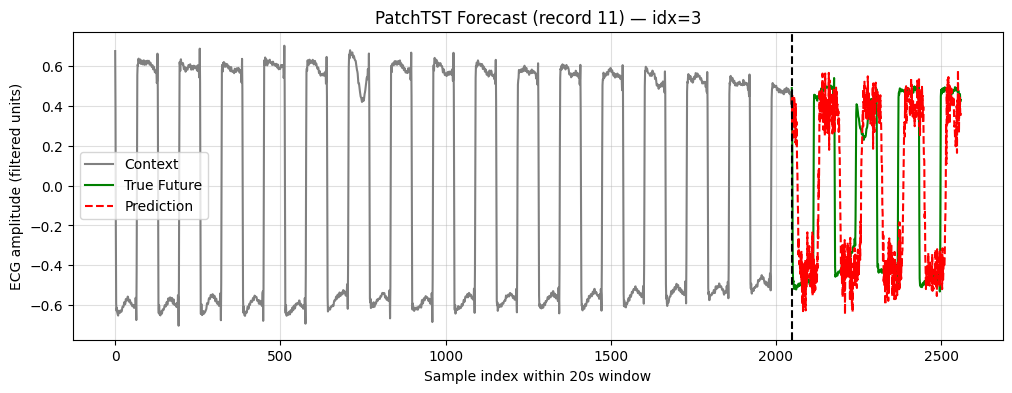

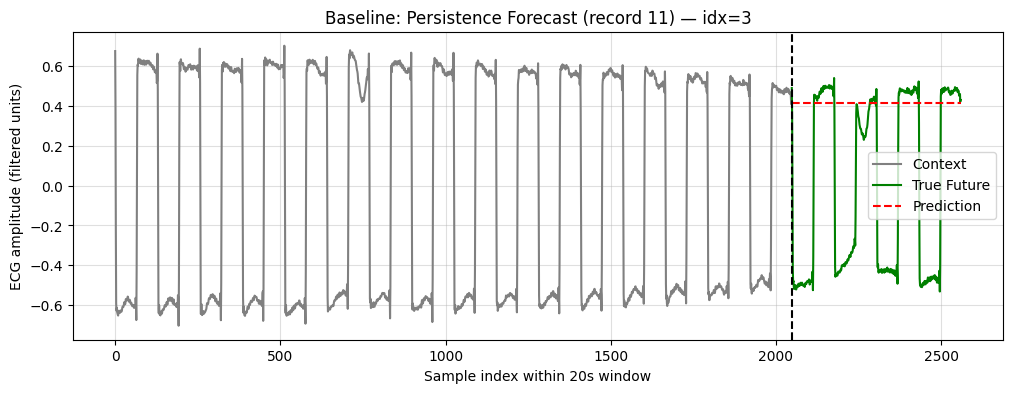

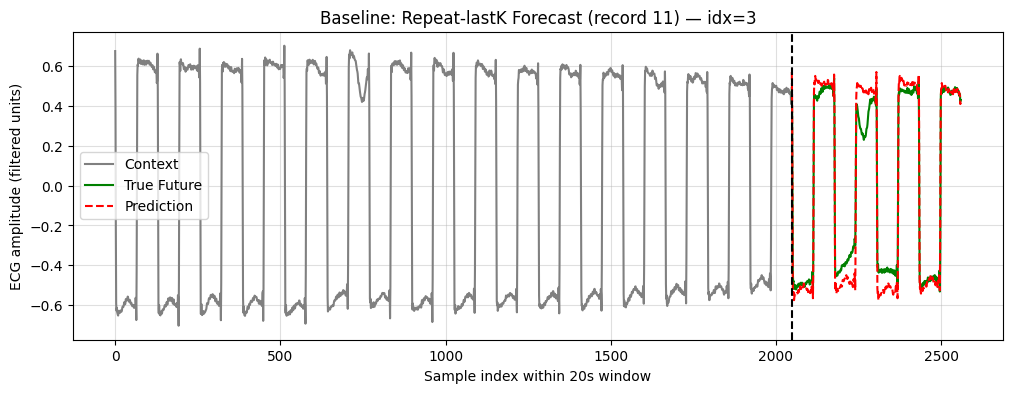

In [7]:
# ============================================================
# 🧩 TASK 6 — Implement Simple Baseline Forecasters (2 points)
# ============================================================
# Goal:
#   Implement two simple, *non-learning* baseline forecasters for
#   raw ECG time-series forecasting.
#
# Why baselines?
#   - They provide a sanity check for deep models like PatchTST
#   - If a complex model cannot beat a simple baseline, something is wrong
#
# You will implement:
#   1) A persistence baseline (last value carried forward)
#   2) A repeat-last-k baseline (repeat the last k samples)
#
# Both functions must:
#   - Work on SCALED data
#   - Return an array of shape (N, FORECAST_SAMPLES)
#
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 🧩 Task 6.1 — Persistence baseline
def persistence_forecast(X_context_scaled, forecast_len):
    """
    Persistence baseline forecaster.

    Strategy:
        Predict the future by repeating the *last observed context value*
        for the entire forecast horizon.

    Parameters
    ----------
    X_context_scaled : np.ndarray
        Shape (N, CONTEXT_SAMPLES), scaled context windows
    forecast_len : int
        Number of samples to predict

    Returns
    -------
    Y_hat : np.ndarray
        Shape (N, forecast_len)
    """
    # TODO:
    # 1) Extract the last value of each context window
    last_vals = X_context_scaled[:, -1]
    # 2) Repeat it forecast_len times along the time axis
    Y_hat = np.repeat(last_vals[:, np.newaxis], forecast_len, axis=1)
    # Hint: np.repeat or np.tile may be useful

    return Y_hat


# 🧩 Task 6.2 — Repeat-last-k baseline
def repeat_last_k_forecast(X_context_scaled, forecast_len, k=256):
    """
    Repeat-last-k baseline forecaster.

    Strategy:
        Use the last k samples of the context window and repeat
        them until the forecast horizon is filled.

    Parameters
    ----------
    X_context_scaled : np.ndarray
        Shape (N, CONTEXT_SAMPLES)
    forecast_len : int
        Number of samples to predict
    k : int
        Number of last context samples to repeat

    Returns
    -------
    Y_hat : np.ndarray
        Shape (N, forecast_len)
    """
    # TODO:
    # 1) Ensure k does not exceed CONTEXT_SAMPLES
    k = min(k, X_context_scaled.shape[1])
    # 2) Extract the last k samples from each context window
    last_k = X_context_scaled[:, -k:]
    # 3) Repeat / tile them to cover forecast_len samples
    reps = int(np.ceil(forecast_len / k))
    tiled = np.tile(last_k, reps)
    # 4) Truncate to exactly forecast_len

    Y_hat = tiled[:, :forecast_len]
    return Y_hat

# ------------------------------
# Create baseline predictions (scaled)
# ------------------------------
Y_base_persist = persistence_forecast(X_test_scaled, FORECAST_SAMPLES)
Y_base_lastk   = repeat_last_k_forecast(X_test_scaled, FORECAST_SAMPLES, k=256)


# ------------------------------
# 3) Metrics helper
# ------------------------------
def compute_metrics(y_true_scaled, y_pred_scaled, scaler):
    mse_s = mean_squared_error(y_true_scaled.flatten(), y_pred_scaled.flatten())
    mae_s = mean_absolute_error(y_true_scaled.flatten(), y_pred_scaled.flatten())
    smp_s = smape(y_true_scaled.flatten(), y_pred_scaled.flatten())

    true_inv = scaler.inverse_transform(y_true_scaled.flatten().reshape(-1, 1)).flatten()
    pred_inv = scaler.inverse_transform(y_pred_scaled.flatten().reshape(-1, 1)).flatten()

    mse_i = mean_squared_error(true_inv, pred_inv)
    mae_i = mean_absolute_error(true_inv, pred_inv)
    smp_i = smape(true_inv, pred_inv)

    return (mse_s, mae_s, smp_s), (mse_i, mae_i, smp_i)

# ------------------------------
# 4) Print comparison
# ------------------------------
patch_metrics_scaled, patch_metrics_inv = compute_metrics(y_true_test, y_pred_test, scaler)
pers_metrics_scaled,  pers_metrics_inv  = compute_metrics(y_true_test, Y_base_persist, scaler)
lastk_metrics_scaled, lastk_metrics_inv = compute_metrics(y_true_test, Y_base_lastk, scaler)

print("\n================= TEST SET COMPARISON (record 11) =================")
print("Scaled space:")
print(f"  PatchTST     → MSE: {patch_metrics_scaled[0]:.6f}, MAE: {patch_metrics_scaled[1]:.6f}, sMAPE: {patch_metrics_scaled[2]:.2f}%")
print(f"  Persistence  → MSE: {pers_metrics_scaled[0]:.6f}, MAE: {pers_metrics_scaled[1]:.6f}, sMAPE: {pers_metrics_scaled[2]:.2f}%")
print(f"  Repeat-lastK → MSE: {lastk_metrics_scaled[0]:.6f}, MAE: {lastk_metrics_scaled[1]:.6f}, sMAPE: {lastk_metrics_scaled[2]:.2f}%")

print("\nOriginal ECG units:")
print(f"  PatchTST     → MSE: {patch_metrics_inv[0]:.6f}, MAE: {patch_metrics_inv[1]:.6f}, sMAPE: {patch_metrics_inv[2]:.2f}%")
print(f"  Persistence  → MSE: {pers_metrics_inv[0]:.6f}, MAE: {pers_metrics_inv[1]:.6f}, sMAPE: {pers_metrics_inv[2]:.2f}%")
print(f"  Repeat-lastK → MSE: {lastk_metrics_inv[0]:.6f}, MAE: {lastk_metrics_inv[1]:.6f}, sMAPE: {lastk_metrics_inv[2]:.2f}%")

# ------------------------------
# 5) Plot helpers (separate figures)
# ------------------------------
def _inverse_1d(arr_scaled, scaler):
    return scaler.inverse_transform(np.asarray(arr_scaled).reshape(-1, 1)).flatten()

def plot_forecast_single(context, true_future, pred_future, title):
    plt.figure(figsize=(12, 4))
    plt.plot(range(CONTEXT_SAMPLES), context, label="Context", color="gray")

    xs = np.arange(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES)
    plt.plot(xs, true_future, label="True Future", color="green")
    plt.plot(xs, pred_future, label="Prediction", color="red", linestyle="--")

    plt.axvline(CONTEXT_SAMPLES, color="black", linestyle="--")
    plt.title(title)
    plt.xlabel("Sample index within 20s window")
    plt.ylabel("ECG amplitude (filtered units)")
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.show()

# ------------------------------
# 6) Choose one window and generate 3 separate plots
# ------------------------------
plot_idx = 3
plot_idx = plot_idx % len(X_test_scaled)
print(f"\nPlotting test sample index: {plot_idx} / {len(X_test_scaled)}")

# Context + True in original units
context = _inverse_1d(X_test_scaled[plot_idx], scaler)
true_future = _inverse_1d(Y_test_scaled[plot_idx], scaler)

# PatchTST prediction in original units
patch_pred = _inverse_1d(y_pred_test[plot_idx], scaler)

# Baseline predictions in original units
persist_pred = _inverse_1d(Y_base_persist[plot_idx], scaler)
lastk_pred   = _inverse_1d(Y_base_lastk[plot_idx], scaler)

# --- Plot 1: PatchTST ---
plot_forecast_single(
    context, true_future, patch_pred,
    title=f"PatchTST Forecast (record 11) — idx={plot_idx}"
)

# --- Plot 2: Persistence baseline ---
plot_forecast_single(
    context, true_future, persist_pred,
    title=f"Baseline: Persistence Forecast (record 11) — idx={plot_idx}"
)

# --- Plot 3: Repeat-lastK baseline ---
plot_forecast_single(
    context, true_future, lastk_pred,
    title=f"Baseline: Repeat-lastK Forecast (record 11) — idx={plot_idx}"
)


From our performance metrics and the plotted examples, we can tell that our **forecasts are not ideal**.

The primary reason for that stems from the conflicting characteristics of the raw Electrocardiogram (ECG) signal: it is both highly periodic and extremely high-frequency.

The model quickly identified the overall rhythm (the low-frequency periodicity of the heartbeat) but struggled to capture the detailed morphology and simultaneously fit the inherent noise. This resulted in a forecast (the red dashed line) that correctly followed the general pattern but was unstable, producing a jagged signal that failed to accurately predict the crucial peak and trough amplitudes.

##🕵 Error analysis

Let's further investigate the cases where our model struggled the most to produce forecasts. This will be your next **🧩 Task**.


Worst #1: window 8, MAE = 2.407524
Worst #2: window 4, MAE = 1.967071
Worst #3: window 9, MAE = 1.963931

Plotting worst window #1: index 8


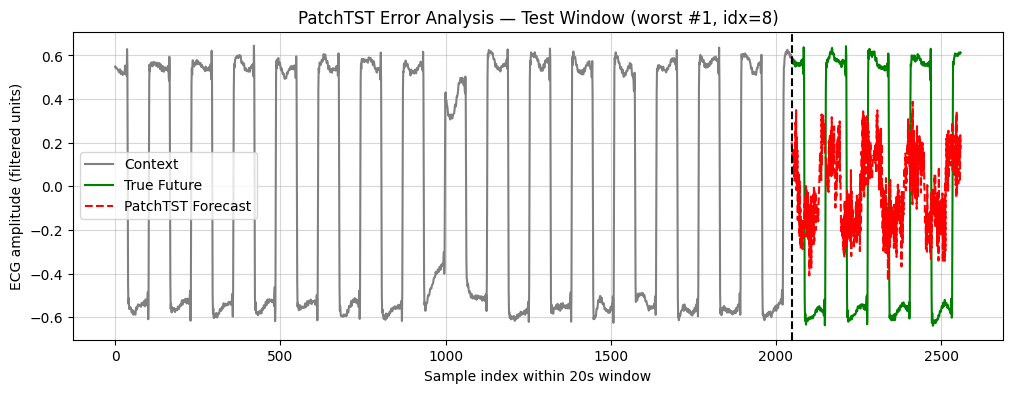


Plotting worst window #2: index 4


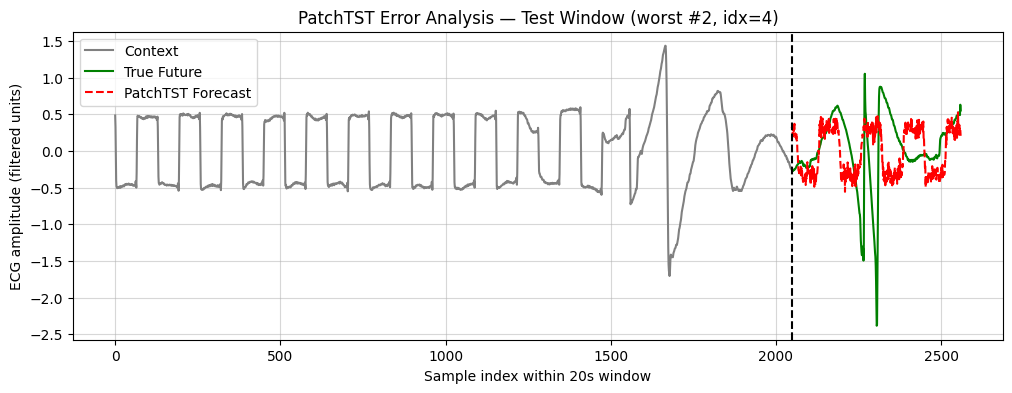


Plotting worst window #3: index 9


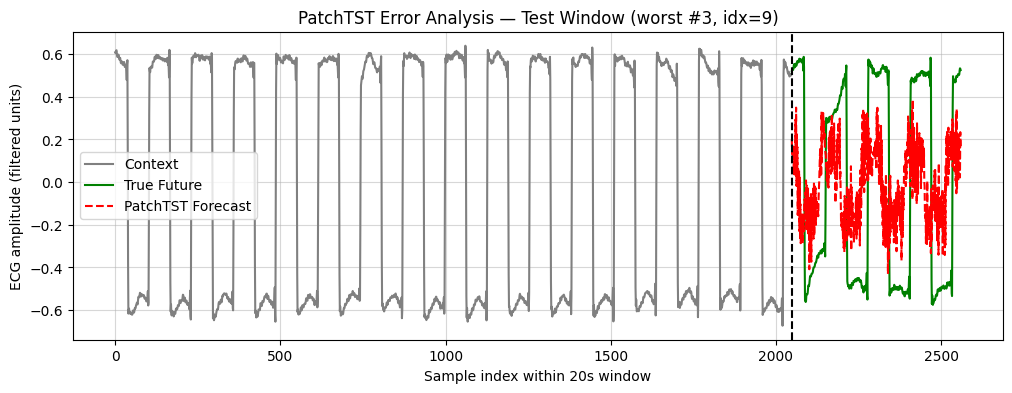

In [8]:
# ============================================================
# 🧩 TASK 7 — Error analysis by window (STUDENT VERSION)
# ============================================================
#
# Goal:
#   Identify *which forecast windows are hardest* for PatchTST.
#
# You will:
#   1) Compute per-window MAE between Y_test_scaled and y_pred_test
#   2) Identify the indices of the top-k WORST windows
#   3) Visualize those windows using the plotting helper below
#
# Why?
#   - Aggregate metrics hide failure cases
#   - Window-level error analysis reveals *when* and *why* the model fails
#
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 🧩 Task 7 — Per-window MAE (1 point)
# ------------------------------------------------------------
def per_window_mae(y_true_scaled, y_pred_scaled, top_k=3):
    """
    Compute MAE per forecast window (row-wise).

    Parameters
    ----------
    y_true_scaled : np.ndarray
        Shape (n_windows, forecast_len)
    y_pred_scaled : np.ndarray
        Shape (n_windows, forecast_len)
    top_k : int
        Number of worst windows to return

    Returns
    -------
    errors : np.ndarray
        Per-window MAE, shape (n_windows,)
    worst_indices : np.ndarray
        Indices of the top_k worst windows (highest MAE),
        sorted from worst to less-worst
    """

    # TODO 1:
    # Compute MAE *per window* (mean over forecast dimension)
    # Hint: axis=1
    errors = np.mean(np.abs(y_true_scaled - y_pred_scaled), axis=1)

    # TODO 2:
    # Find indices of the top_k largest errors
    # Hint: np.argsort
    worst_indices = np.argsort(errors)[-top_k:][::-1]

    # TODO 3:
    # Print the worst windows and their MAE values
    # (format is up to you)
    for i, idx in enumerate(worst_indices, start=1):
        print(f"Worst #{i}: window {idx}, MAE = {errors[idx]:.6f}")

    return errors, worst_indices



# ------------------------------------------------------------
# Helper: plot a single test window
# ------------------------------------------------------------
def plot_test_window(idx, rank=None):
    """
    Plot context + true future + PatchTST prediction
    for a single test window.
    """
    n_test = len(X_test_scaled)
    idx = int(idx) % n_test

    if rank is not None:
        print(f"\nPlotting worst window #{rank}: index {idx}")
    else:
        print(f"\nPlotting test window index: {idx}")

    # --- scaled data ---
    context_scaled = X_test_scaled[idx]
    true_future_scaled = Y_test_scaled[idx]
    pred_future_scaled = y_pred_test[idx]

    # --- inverse transform ---
    context = scaler.inverse_transform(context_scaled.reshape(-1, 1)).flatten()
    true_future = scaler.inverse_transform(true_future_scaled.reshape(-1, 1)).flatten()
    pred_future = scaler.inverse_transform(pred_future_scaled.reshape(-1, 1)).flatten()

    # --- plot ---
    plt.figure(figsize=(12, 4))
    plt.plot(range(CONTEXT_SAMPLES), context, color="gray", label="Context")
    plt.plot(
        range(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES),
        true_future,
        color="green",
        label="True Future",
    )
    plt.plot(
        range(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES),
        pred_future,
        color="red",
        linestyle="--",
        label="PatchTST Forecast",
    )
    plt.axvline(CONTEXT_SAMPLES, color="black", linestyle="--")
    plt.xlabel("Sample index within 20s window")
    plt.ylabel("ECG amplitude (filtered units)")
    title_suffix = f"(worst #{rank}, idx={idx})" if rank is not None else f"(idx={idx})"
    plt.title(f"PatchTST Error Analysis — Test Window {title_suffix}")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

# ------------------------------------------------------------
# 7.3 Run analysis + plot worst windows
# ------------------------------------------------------------
window_errors, worst_indices = per_window_mae(y_true_test, y_pred_test, top_k=3)

if worst_indices.size == 0:
    print("⚠️ No windows available to plot.")
else:
    for rank, idx in enumerate(worst_indices, start=1):
        plot_test_window(idx, rank=rank)



We could better guide the model by using a larger patch size (PATCH_LEN) to give the Transformer a better context of the entire heartbeat and increasing the smoothing penalty (LAMBDA_SMOOTH) to suppress the prediction's high-frequency instability.

However, the most important step to correct this would be to heavily **increase the training budget** (epochs and the size of our training set). We were leveriging only a very limited subset of our training data and allowed training for 10 epochs only.

We did this becasue we are **constrained time-wise and processing-wise** in our setup. In such scenarios, or when only limited training data is available - which is often the case in medical scenarios - reverting to a more lightweight model could be beneficial.




---


## 🤖 Foundation Models for Time Series Forecasting
Foundation Models (FMs) for time series forecasting are a new paradigm inspired by Large Language Models (LLMs), trained on massive, diverse datasets spanning numerous time series from different domains.

By learning generalized temporal patterns, trends, and seasonality from vast amounts of data, these models develop a universal understanding of time series dynamics.

The key advantage of FMs is their zero-shot or few-shot learning capability, meaning they can accurately forecast new, unseen time series without needing task-specific training or fine-tuning, dramatically reducing the effort required to deploy AI in fields like medicine.

These models are typically built upon Transformer architectures, adapting the self-attention mechanism to capture long-range dependencies in sequential data. Prominent examples of time series Foundation Models include TimeGPT-1, Chronos (by Amazon), TimesFM (by Google), and Lag-Llama.

## ⏰ Zero-shot forecasting using Chronos-2

The original Chronos family is based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context.

The latest iteration offers zero-shot support for univariate, multivariate, and covariate-informed forecasting tasks.

Despite being a foundation model, Chronos is relatively light-weight, not requiring heavy resources for inference.



---

Useful links



*   Github: https://github.com/amazon-science/chronos-forecasting
*   Paper: Ansari et al. 2024, arXiv:2403.07815



In [9]:
!pip install chronos-forecasting  # or: pip install git+https://github.com/amazon-science/chronos-forecasting.git
from chronos import Chronos2Pipeline
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

✅ data/42: 600 windows of 2560 samples each (fs=128 Hz)
Context samples: 2048, Forecast samples: 512
X shape: (600, 2048), Y shape: (600, 512)
✅ data/11: 200 windows of 2560 samples each (fs=128 Hz)
Context samples: 2048, Forecast samples: 512
X shape: (200, 2048), Y shape: (200, 512)

Final RAW ECG shapes:
  TRAIN (42): X=(600, 2048), Y=(600, 512)
  TEST  (11): X=(200, 2048),     Y=(200, 512)

Using device for Chronos-2: cpu

Sample of Chronos context_df (record 11 windows):
   id               timestamp    target
0   0 2000-01-01 00:00:00.000  0.009029
1   0 2000-01-01 00:00:00.001  0.015993
2   0 2000-01-01 00:00:00.002  0.016768
3   0 2000-01-01 00:00:00.003  0.008288
4   0 2000-01-01 00:00:00.004  0.001669

Sample of Chronos prediction DataFrame:
   id               timestamp target_name  predictions       0.5
0   0 2000-01-01 00:00:02.048      target     0.312478  0.312478
1   0 2000-01-01 00:00:02.049      target     0.233135  0.233135
2   0 2000-01-01 00:00:02.050      target  

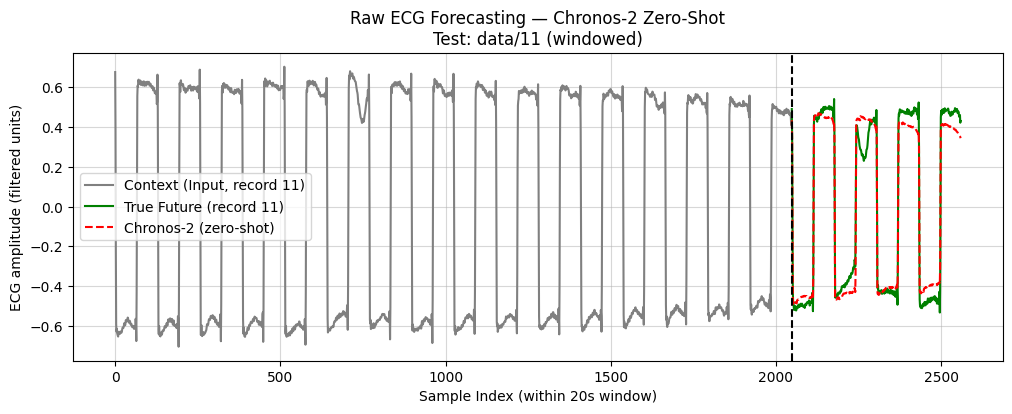

In [10]:
# ============================================================
# ⚡ Raw ECG Forecasting with Chronos-2 (Zero/Few-Shot)
# Context/Forecast windows from data/11 (+ data/42 preprocessed for consistency)
# No Task here - just try to understand the code and execute it.
# ============================================================

import numpy as np
import wfdb
from scipy import signal
from wfdb import processing as wfproc
import matplotlib.pyplot as plt
import random

# ---------------------- Global Seeds -------------------------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# --- Configuration for RAW ECG (in samples) ---
WINDOW_SECONDS   = 20.0     # total window length (e.g. 20 s)
CONTEXT_RATIO    = 0.8      # 80% context, 20% forecast
WINDOW_STEP_SEC  = WINDOW_SECONDS  # non-overlapping windows

LEAD_INDEX = 0
LOWCUT, HIGHCUT = 0.5, 40.0
FILTER_ORDER = 3

MAX_WINDOWS_PER_RECORD = 2000   # safety cap per record
MAX_TRAIN_WINDOWS      = 600    # from record 42 (kept for consistency)
MAX_TEST_WINDOWS       = 200    # from record 11 (used for evaluation)

# ============================================================
# Preprocessing helpers (for raw ECG)
# ============================================================
def butter_bandpass(sig, fs, low=LOWCUT, high=HIGHCUT, order=FILTER_ORDER):
    nyq = 0.5 * fs
    low_norm = max(0.001, low / nyq)
    high_norm = min(0.999, high / nyq)
    b, a = signal.butter(order, [low_norm, high_norm], btype='band')
    sig_f = signal.filtfilt(b, a, sig)
    return sig_f

def process_record_ecg_windows(record_path,
                               window_seconds=WINDOW_SECONDS,
                               step_seconds=WINDOW_STEP_SEC,
                               max_windows=MAX_WINDOWS_PER_RECORD):
    """Return raw ECG windows (N, window_samples) for a single record."""
    try:
        rec = wfdb.rdrecord(record_path)
    except FileNotFoundError:
        raise RuntimeError(f"Cannot find record at {record_path}. Did you download it?")

    fs = rec.fs
    sig = rec.p_signal[:, LEAD_INDEX].astype(float)
    sig_f = butter_bandpass(sig, fs)

    window_samples = int(window_seconds * fs)
    step_samples   = int(step_seconds * fs)

    if len(sig_f) < window_samples:
        raise RuntimeError(
            f"Too few samples ({len(sig_f)}) for {window_samples}-sample windows in {record_path}"
        )

    windows = [
        sig_f[i:i + window_samples]
        for i in range(0, len(sig_f) - window_samples + 1, step_samples)
    ]
    windows = np.array(windows)

    if len(windows) > max_windows:
        windows = windows[:max_windows]

    print(f"✅ {record_path}: {len(windows)} windows of {window_samples} samples each (fs={fs} Hz)")
    return windows, fs, window_samples

def split_context_forecast_samples(windows, context_ratio=CONTEXT_RATIO):
    """Split sample windows into context and forecast parts."""
    window_samples = windows.shape[1]
    context_samples = int(window_samples * context_ratio)
    forecast_samples = window_samples - context_samples

    X = windows[:, :context_samples]
    Y = windows[:, context_samples:]
    print(f"Context samples: {context_samples}, Forecast samples: {forecast_samples}")
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y, context_samples, forecast_samples

# ============================================================
# Build TRAIN from data/42, TEST from data/11 (RAW ECG)
# (Chronos-2 will be evaluated on data/11 windows)
# ============================================================
try:
    # --- TRAIN: record 42 (not used for Chronos training in zero-shot,
    #     but kept for symmetry/comparison with PatchTST) ---
    win_42, fs_42, window_samples_42 = process_record_ecg_windows(
        "data/42",
        window_seconds=WINDOW_SECONDS,
        step_seconds=WINDOW_STEP_SEC,
        max_windows=MAX_TRAIN_WINDOWS,
    )
    X_train_all, Y_train_all, CONTEXT_SAMPLES, FORECAST_SAMPLES = split_context_forecast_samples(
        win_42, context_ratio=CONTEXT_RATIO
    )

    # --- TEST: record 11 ---
    win_11, fs_11, window_samples_11 = process_record_ecg_windows(
        "data/11",
        window_seconds=WINDOW_SECONDS,
        step_seconds=WINDOW_STEP_SEC,
        max_windows=MAX_TEST_WINDOWS,
    )
    X_test, Y_test, CONTEXT_SAMPLES_test, FORECAST_SAMPLES_test = split_context_forecast_samples(
        win_11, context_ratio=CONTEXT_RATIO
    )

    if fs_42 != fs_11:
        print(f"⚠️ Warning: fs_42={fs_42} Hz, fs_11={fs_11} Hz (not identical).")
    if (CONTEXT_SAMPLES != CONTEXT_SAMPLES_test) or (FORECAST_SAMPLES != FORECAST_SAMPLES_test):
        raise RuntimeError("Context/forecast sample lengths differ between records 42 and 11.")

except Exception as e:
    print(f"❌ Error while building train/test from records 42 and 11 (raw ECG): {e}")
    raise SystemExit(1)

print(f"\nFinal RAW ECG shapes:")
print(f"  TRAIN (42): X={X_train_all.shape}, Y={Y_train_all.shape}")
print(f"  TEST  (11): X={X_test.shape},     Y={Y_test.shape}")

N_TEST = len(X_test)

# ============================================================
# Chronos-2 Zero-Shot Forecasting on RAW ECG windows (record 11)
# ============================================================
import pandas as pd
import torch
from chronos import Chronos2Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_true - y_pred) / denom)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device for Chronos-2: {device}")

# Load Chronos-2 zero-shot forecaster
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map=device)

# Build long-format context DataFrame from TEST windows (record 11)
# Each window is a separate short time series with its own id
# id: window index, timestamp: synthetic index, target: ECG amplitude
timestamps = pd.date_range("2000-01-01", periods=CONTEXT_SAMPLES, freq="ms")  # 1 ms spacing (arbitrary)

records = []
for i in range(N_TEST):
    for t_idx, value in enumerate(X_test[i]):
        records.append({"id": i, "timestamp": timestamps[t_idx], "target": float(value)})

context_df = pd.DataFrame(records)
print("\nSample of Chronos context_df (record 11 windows):")
print(context_df.head())

# Run zero-shot forecasting for all test windows
pred_df = pipeline.predict_df(
    context_df,
    prediction_length=FORECAST_SAMPLES,
    quantile_levels=[0.5],      # median as point forecast
    id_column="id",
    timestamp_column="timestamp",
    target="target",
)

print("\nSample of Chronos prediction DataFrame:")
print(pred_df.head())

# ============================================================
# Collect predictions per window and compute metrics
# ============================================================
# Chronos output: one row per (id, future timestamp)
# We expect a column "0.5" for the median forecast; if not, fall back to "predictions"
if "0.5" in pred_df.columns:
    pred_col = "0.5"
elif "predictions" in pred_df.columns:
    pred_col = "predictions"
else:
    raise RuntimeError(f"Unexpected Chronos-2 output columns: {pred_df.columns}")

y_pred = np.zeros_like(Y_test, dtype=float)

for i in range(N_TEST):
    series_pred = (
        pred_df[pred_df["id"] == i]
        .sort_values("timestamp")[pred_col]
        .to_numpy()
    )
    if len(series_pred) < FORECAST_SAMPLES:
        raise RuntimeError(
            f"Chronos-2 returned only {len(series_pred)} steps for id={i}, "
            f"expected {FORECAST_SAMPLES}"
        )
    y_pred[i, :] = series_pred[:FORECAST_SAMPLES]

y_true = Y_test.copy()

# Metrics in original ECG units (filtered amplitude)
mse_ecg   = mean_squared_error(y_true.flatten(), y_pred.flatten())
mae_ecg   = mean_absolute_error(y_true.flatten(), y_pred.flatten())
smape_ecg = smape(y_true.flatten(), y_pred.flatten())

print("\n===== Chronos-2 Zero-Shot Performance (RAW ECG, record 11 windows) =====")
print(f"MSE   : {mse_ecg:.6f}")
print(f"MAE   : {mae_ecg:.6f}")
print(f"sMAPE: {smape_ecg:.2f}%")

# ============================================================
# Visualize one example forecast (record 11, RAW ECG)
# ============================================================
example_idx = 3
if example_idx >= N_TEST:
    example_idx = 0

context = X_test[example_idx]
true_future = Y_test[example_idx]
pred_future = y_pred[example_idx]

plt.figure(figsize=(12, 4))
plt.plot(range(CONTEXT_SAMPLES), context, color='gray', label="Context (Input, record 11)")
plt.plot(
    range(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES),
    true_future,
    color='green',
    label="True Future (record 11)",
)
plt.plot(
    range(CONTEXT_SAMPLES, CONTEXT_SAMPLES + FORECAST_SAMPLES),
    pred_future,
    color='red',
    linestyle='--',
    label="Chronos-2 (zero-shot)",
)
plt.axvline(CONTEXT_SAMPLES, color='black', linestyle='--')
plt.xlabel("Sample Index (within 20s window)")
plt.ylabel("ECG amplitude (filtered units)")
plt.title("Raw ECG Forecasting — Chronos-2 Zero-Shot\nTest: data/11 (windowed)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


## 🏁 Conclusion - Part 2

In this second part of the exercise, we moved beyond classification and explored time series forecasting on raw ECG signals.

We implemented and trained a Transformer-based forecasting model (PatchTST), training on one patient record and testing on a different one. This simplified setup mirrors real clinical deployment scenarios, where models must generalize across patients rather than memorizing individual signal characteristics.

We identified shortcomings of our simplief modelling approach through trageted error analysis and comparison with baseline forecasters.

By implementing a time series foundation model (Chronos-2), we saw how such models can deliver superior zero-shot performance in resource-constrained environments, where training complex models on large datasets is not feasible.

